# **Desarrollo de Modelos Analíticos (Machine Learning)**
## TP Individual - Entrega Final

## 01) Preparar Entorno

### _Montar Drive:_

> Ejecutar una sola vez

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### _Importar Bibliotecas de Uso General_

In [2]:
import numpy as np # para arrays, Series, List, Sets # V1.23.5
import pandas as pd # para dataframes # V1.5.3

### _Funciones Auxiliares_

In [3]:
def color(string, prefijoColor):
  return f'{prefijoColor}{string}\u001B[0m'

def VERDE(string):
  return color(string, '\x1B[32m')

def AZUL(string):
  return color(string, '\u001B[36m')

def ROJO(string):
  return color(string, '\x1B[31m')

#### Biblioteca Testing

In [4]:
def assertEquals(expected, actual):
  if(expected == actual):
    print(f'   {VERDE("[Ok]")}')
  else:
    print(f'    {ROJO("[Fail]: got {actual} but {expected} was expected")}')

def assertEmpty(list):
  if isinstance(list, pd.Series):
    list = list.to_list()
  assertEquals('[]', f'{list}')

def test(description, doExecute):
  print(f'[TEST] {description}:')
  doExecute()

### _Lectura de datos de Archivo .csv_

In [5]:
# @title Path
CARPETA_DRIVE = "drive/MyDrive/Faq/Machine Learning/TP Individual/data.csv" # @param {type:"string"}
SEPARADOR = "|" # @param {type:"string"}

data_drive = pd.read_csv(CARPETA_DRIVE, sep=SEPARADOR, dtype={'client_id': np.int64})

test('La cantidad de datos leidos es correcta', lambda: assertEquals((238615, 77), data_drive.shape))

[TEST] La cantidad de datos leidos es correcta:
   [Ok]


In [6]:
datosOriginales = data_drive

## 02) Filtrado de Universo y Target

In [7]:
# @title ### _Clientes con antigüedad suficiente para ser tenidos en cuenta_
MESES = 9 # @param {type:"integer"}

> Aclaración: 9 Meses = 6 de antigüedad + 1 de Lead Window + 2 de Prediction Window

In [8]:
def clientes_con_N_meses_de_antiguedad(meses):
  antiguedadClientes = datosOriginales.groupby('client_id')['Month'].count().reset_index()
  operacionesDeClientesConAntiguedad = antiguedadClientes[antiguedadClientes.Month>=meses]
  return operacionesDeClientesConAntiguedad['client_id']

# Filtro por antigüedad
idClientes9Meses = clientes_con_N_meses_de_antiguedad(meses = MESES)

test('La cantidad de clientes con 9 meses de antigüedad es correcta',
     lambda: assertEquals(26483, len(clientes_con_N_meses_de_antiguedad(meses = 9)))
)

[TEST] La cantidad de clientes con 9 meses de antigüedad es correcta:
   [Ok]


### _Clientes Universo_

In [9]:
noCobranding2019 = datosOriginales[
     (datosOriginales.Month == '2019-01-01' )
    & (datosOriginales.CreditCard_CoBranding=='No')
];

antiguedad9YnoCobrandingEn2019 = noCobranding2019.merge(idClientes9Meses, on="client_id", how='inner')[['client_id']].drop_duplicates()

### _Filtro según Package Active_

In [10]:
# Datos de Clientes con Antiguedad 9 y No Cobranding en 2019
antiguedad9_noCb2019 = datosOriginales.merge(antiguedad9YnoCobrandingEn2019[['client_id']], on='client_id', how='inner')

# Lo anterior + no Package Active
antiguedad9_noCb2019_noPA = antiguedad9_noCb2019[
  (  (antiguedad9_noCb2019.Month == '2019-01-01')  & (antiguedad9_noCb2019.Package_Active=='No') )
][['client_id']].merge(antiguedad9_noCb2019, on='client_id', how='inner')

# Clientes seleccionados para entrenamiento
idClientesTrain = antiguedad9_noCb2019_noPA[['client_id']].drop_duplicates()

test('La cantidad de clientes para entrenamiento es correcta',
     lambda: assertEquals(23191, len(idClientesTrain))
)

[TEST] La cantidad de clientes para entrenamiento es correcta:
   [Ok]


### _Clientes Target_


In [11]:
# Lo anterior + target activo en marzo o abril 2019
antiguedad9_noCb2019_noPA_targetMoA2019 = antiguedad9_noCb2019_noPA[
    (
      ( (antiguedad9_noCb2019_noPA.Month == '2019-03-01') | (antiguedad9_noCb2019_noPA.Month == '2019-04-01') ) & (antiguedad9_noCb2019_noPA.Target==1)
    )
]

# Target final
idClientesTarget = antiguedad9_noCb2019_noPA_targetMoA2019[['client_id']].drop_duplicates()

test('La cantidad de clientes para target se calcula correctamente',
  lambda: assertEquals((6823, 1), idClientesTarget.shape)
)

[TEST] La cantidad de clientes para target se calcula correctamente:
   [Ok]


## 03) Lead y Prediction Window

- Lead Window: Febrero 2019
- Prediction Window: Marzo y Abril 2019

In [12]:
trainingWindow = datosOriginales[datosOriginales.Month.le('2019-02')]
dataTrain = trainingWindow.merge(idClientesTrain, on='client_id', how='inner')

## 04) Identity Features

In [13]:
universo = idClientesTarget.copy()
universo['REAL_TARGET'] = True
universo = universo.merge(idClientesTrain, on='client_id', how='right')
universo.REAL_TARGET.fillna(False, inplace=True)

universo.REAL_TARGET.value_counts()

False    16368
True      6823
Name: REAL_TARGET, dtype: int64

In [14]:
datosUltimoMesDeEstudio = dataTrain[dataTrain.Month=='2019-01-01']

In [15]:
# Categorías de datos:
CREDITCARD_PRODUCTS_COLUMNS = ['CreditCard_Active', 'CreditCard_Premium', 'CreditCard_CoBranding', 'DebitCard_Active']
SAVING_ACCOUNTS_PRODUCTS_COLUMNS = ['SavingAccount_Active_ARG', 'SavingAccount_Active_ARG_Salary', 'SavingAccount_Active_DOLLAR']
INSURANCE_PRODUCTS_COLUMNS = ['Insurance_Life', 'Insurance_Home', 'Insurance_Accidents', 'Insurance_ATM', 'Insurance_Mobile', 'Insurance_Unemployment'] # Esto se podria hacer con un filtro. Sino moverlo para arriba.
OTHER_PRODUCTS_COLUMNS =  ['Loan_Active', 'Mortgage_Active', 'Investment_Active']

# Identity Features obtenidos del último mes de estudio:
identityFeatures = datosUltimoMesDeEstudio[
  [
    'client_id', 'Sex', 'Region' # Personal data
    , 'Email', 'Mobile' # Contact data
    , 'First_product_dt', 'Last_product_dt' # First and last *date* (dt) of purchase of products
  ]
  # Purchased products:
    + CREDITCARD_PRODUCTS_COLUMNS + SAVING_ACCOUNTS_PRODUCTS_COLUMNS + INSURANCE_PRODUCTS_COLUMNS + OTHER_PRODUCTS_COLUMNS +
  [
    'CreditCard_Product' ### Aca son todos null.
  ]
].copy() # Acá hago copy porque después voy a usar inplace=True para hacer mas facil.

##Null columns --> Región, CreditCard_Product

identityFeatures.replace({'Yes':True, 'No':False}, inplace=True) ### Duda: Estos no son identity
identityFeatures.rename(columns={'Sex': 'Genre', 'Email': 'Has_Email', 'Mobile': 'Has_Mobile'}, inplace=True)

universoConIdentityFeatures = universo.merge(identityFeatures, on='client_id', how='inner')

universoConIdentityFeatures.head()

,client_id,REAL_TARGET,Genre,Region,Has_Email,Has_Mobile,First_product_dt,Last_product_dt,CreditCard_Active,CreditCard_Premium,...,Insurance_Life,Insurance_Home,Insurance_Accidents,Insurance_ATM,Insurance_Mobile,Insurance_Unemployment,Loan_Active,Mortgage_Active,Investment_Active,CreditCard_Product
0,5856970,True,F,NaN,True,True,2013-10-23,2019-01-10,True,False,...,False,False,False,False,False,False,False,False,True,NaN
1,6371753,False,F,NaN,False,True,2015-07-29,2018-06-02,False,False,...,False,False,False,False,False,False,False,False,False,NaN
2,5928737,False,M,NaN,True,True,2016-08-31,2018-12-27,False,False,...,False,False,False,False,False,False,False,False,False,NaN
3,475064,False,F,NaN,True,True,2014-07-13,2017-11-30,True,False,...,False,False,False,False,False,False,False,False,False,NaN
4,3615172,False,M,NaN,False,True,2017-12-27,2017-12-28,False,False,...,False,False,False,False,False,False,False,False,False,NaN


## 05) Transform Features

### _Grupos Etarios_

In [16]:
_entre_anios = lambda min, max: f'Entre {min} y {max} años'

rangos = [(18, 29), (30, 39), (40, 49), (50, 59), (60, 64), (65, 69)]
rangosAsString = map(lambda rg: _entre_anios(*rg), rangos)
gruposEtarios = ['Menor a 18 años'] + list(rangosAsString) + ['Mayor a 70 años']

test('Grupos etarios se asignan bien', lambda:
  assertEquals([(0, 'Menor a 18 años'), (1, 'Entre 18 y 29 años'), (2, 'Entre 30 y 39 años'), (3, 'Entre 40 y 49 años'), (4, 'Entre 50 y 59 años'), (5, 'Entre 60 y 64 años'), (6, 'Entre 65 y 69 años'), (7, 'Mayor a 70 años')], list(enumerate(gruposEtarios)))
)

[TEST] Grupos etarios se asignan bien:
   [Ok]


In [17]:
universoConGruposEtarios = universoConIdentityFeatures.merge(datosUltimoMesDeEstudio[['client_id', 'Client_Age_grp']], on='client_id', how='inner')
universoConGruposEtarios.Client_Age_grp.replace({key: i for i, key in enumerate(gruposEtarios)}, inplace=True)

universoConGruposEtarios.head()

,client_id,REAL_TARGET,Genre,Region,Has_Email,Has_Mobile,First_product_dt,Last_product_dt,CreditCard_Active,CreditCard_Premium,...,Insurance_Home,Insurance_Accidents,Insurance_ATM,Insurance_Mobile,Insurance_Unemployment,Loan_Active,Mortgage_Active,Investment_Active,CreditCard_Product,Client_Age_grp
0,5856970,True,F,NaN,True,True,2013-10-23,2019-01-10,True,False,...,False,False,False,False,False,False,False,True,NaN,7
1,6371753,False,F,NaN,False,True,2015-07-29,2018-06-02,False,False,...,False,False,False,False,False,False,False,False,NaN,4
2,5928737,False,M,NaN,True,True,2016-08-31,2018-12-27,False,False,...,False,False,False,False,False,False,False,False,NaN,2
3,475064,False,F,NaN,True,True,2014-07-13,2017-11-30,True,False,...,False,False,False,False,False,False,False,False,NaN,7
4,3615172,False,M,NaN,False,True,2017-12-27,2017-12-28,False,False,...,False,False,False,False,False,False,False,False,NaN,3


### _Ajuste tipos de dato_
 - Fechas
 - Client_id

In [18]:
_types = universoConGruposEtarios[['First_product_dt', 'Last_product_dt', 'client_id']].dtypes
print(f'Formato Anterior:\n\n{_types}\n\n')

universoConGruposEtariosYFechasParseadas = universoConGruposEtarios
universoConGruposEtariosYFechasParseadas['First_product_dt'] = pd.to_datetime(universoConGruposEtariosYFechasParseadas['First_product_dt'])
universoConGruposEtariosYFechasParseadas['Last_product_dt'] = pd.to_datetime(universoConGruposEtariosYFechasParseadas['Last_product_dt'])

_types = universoConGruposEtariosYFechasParseadas[['First_product_dt', 'Last_product_dt', 'client_id']].dtypes
print(f'Formato Actualizado:\n\n{_types}')

Formato Anterior:

First_product_dt    object
Last_product_dt     object
client_id            int64
dtype: object


Formato Actualizado:

First_product_dt    datetime64[ns]
Last_product_dt     datetime64[ns]
client_id                    int64
dtype: object


### _Fechas_

In [19]:
from datetime import datetime
MES_ACTUAL = pd.to_datetime('2019-01-01')

def contar_meses_entre(fecha0, fecha):
  return (fecha-fecha0).dt.days / 30

def contar_meses_transcurridos_desde(fecha):
  return contar_meses_entre(fecha, MES_ACTUAL)

aux = universoConGruposEtariosYFechasParseadas.copy()
aux['MonthsBetween_LastFirstProduct'] = contar_meses_entre(aux['First_product_dt'], aux['Last_product_dt'])
aux['MonthsSince_FirstProduct'] = contar_meses_transcurridos_desde(aux['First_product_dt'])
aux['MonthsSince_LastProduct'] = contar_meses_transcurridos_desde(aux['Last_product_dt'])

universo_GruposEtarios_FechasParseadas_MesesContados = aux.drop(columns = ['First_product_dt', 'Last_product_dt'])
del aux

universo_GruposEtarios_FechasParseadas_MesesContados.head()

,client_id,REAL_TARGET,Genre,Region,Has_Email,Has_Mobile,CreditCard_Active,CreditCard_Premium,CreditCard_CoBranding,DebitCard_Active,...,Insurance_Mobile,Insurance_Unemployment,Loan_Active,Mortgage_Active,Investment_Active,CreditCard_Product,Client_Age_grp,MonthsBetween_LastFirstProduct,MonthsSince_FirstProduct,MonthsSince_LastProduct
0,5856970,True,F,NaN,True,True,True,False,False,True,...,False,False,False,False,True,NaN,7,63.500000,63.200000,-0.300000
1,6371753,False,F,NaN,False,True,False,False,False,True,...,False,False,False,False,False,NaN,4,34.633333,41.733333,7.100000
2,5928737,False,M,NaN,True,True,False,False,False,True,...,False,False,False,False,False,NaN,2,28.266667,28.433333,0.166667
3,475064,False,F,NaN,True,True,True,False,False,True,...,False,False,False,False,False,NaN,7,41.200000,54.433333,13.233333
4,3615172,False,M,NaN,False,True,False,False,False,True,...,False,False,False,False,False,NaN,3,0.033333,12.333333,12.300000


### _Cantidad de productos contratados_

In [20]:
NOT_INSURANCE_PRODUCTS_COLUMNS = CREDITCARD_PRODUCTS_COLUMNS + SAVING_ACCOUNTS_PRODUCTS_COLUMNS + OTHER_PRODUCTS_COLUMNS

gefp = universo_GruposEtarios_FechasParseadas_MesesContados[['client_id'] + NOT_INSURANCE_PRODUCTS_COLUMNS + INSURANCE_PRODUCTS_COLUMNS].copy() # Sin el copy tira warning porque abajo yo estoy setteando una columna que se aplicaria sobre el original.

gefp['ActiveInsurances_Count'] = gefp[INSURANCE_PRODUCTS_COLUMNS].sum(axis=1)
gefp['ActiveProducts_Count'] = gefp[NOT_INSURANCE_PRODUCTS_COLUMNS + ['ActiveInsurances_Count']].sum(axis=1).astype(int)

print('***** Value Counts *****')
print(f'- Active Insurances\n{gefp.ActiveInsurances_Count.value_counts()}\n')
print(f'- Active Products\n{gefp.ActiveProducts_Count.value_counts()}\n')

universoConGruposEtarios_FechasParseadas_ProductosContratados = gefp[['client_id', 'ActiveInsurances_Count', 'ActiveProducts_Count']].merge(universo_GruposEtarios_FechasParseadas_MesesContados, on='client_id', how='inner')
print(universoConGruposEtarios_FechasParseadas_ProductosContratados.shape)

***** Value Counts *****
- Active Insurances
0    23191
Name: ActiveInsurances_Count, dtype: int64

- Active Products
3    5522
1    5444
4    5110
2    3412
5    2837
6     766
7      78
0      17
8       5
Name: ActiveProducts_Count, dtype: int64

(23191, 29)


### Transform Features Finales

In [21]:
universoConTransformFeatures = universoConGruposEtarios_FechasParseadas_ProductosContratados
universoConTransformFeatures.head()

,client_id,ActiveInsurances_Count,ActiveProducts_Count,REAL_TARGET,Genre,Region,Has_Email,Has_Mobile,CreditCard_Active,CreditCard_Premium,...,Insurance_Mobile,Insurance_Unemployment,Loan_Active,Mortgage_Active,Investment_Active,CreditCard_Product,Client_Age_grp,MonthsBetween_LastFirstProduct,MonthsSince_FirstProduct,MonthsSince_LastProduct
0,5856970,0,5,True,F,NaN,True,True,True,False,...,False,False,False,False,True,NaN,7,63.500000,63.200000,-0.300000
1,6371753,0,3,False,F,NaN,False,True,False,False,...,False,False,False,False,False,NaN,4,34.633333,41.733333,7.100000
2,5928737,0,3,False,M,NaN,True,True,False,False,...,False,False,False,False,False,NaN,2,28.266667,28.433333,0.166667
3,475064,0,3,False,F,NaN,True,True,True,False,...,False,False,False,False,False,NaN,7,41.200000,54.433333,13.233333
4,3615172,0,2,False,M,NaN,False,True,False,False,...,False,False,False,False,False,NaN,3,0.033333,12.333333,12.300000


#### Training window con transform features

In [22]:
trainingWindowConTransformFeatures = trainingWindow.copy()

In [23]:
CUSTOM_COLUMNS = set()

In [24]:
def agregarCociente(tabla, nombreNuevaColumna, dividendo, divisor):
  t = tabla
  t[nombreNuevaColumna] = np.where(
      t[divisor] == 0,
      t[dividendo], # equivalente a /1, partiendo del supuesto de que en la unidad del atributo 1 es poca diferencia.
      t[dividendo]/t[divisor]
  )
  CUSTOM_COLUMNS.add(nombreNuevaColumna)

agregarCociente(trainingWindowConTransformFeatures, 'Debit_vs_CreditCard', 'SavingAccount_DebitCard_Spend_Amount', 'CreditCard_Total_Spending')
agregarCociente(trainingWindowConTransformFeatures, 'SavingAccount_Debit_vs_CreditCard', 'SavingAccount_DebitCard_Spend_Amount', 'CreditCard_Total_Spending')

In [25]:
OPERATIONS_COLUMNS = [
    'Operations_Bank', 'Operations_Terminal', 'Operations_HomeBanking','Operations_Mobile', 'Operations_Ivr', 'Operations_Telemarketer','Operations_ATM'
]

x = map(lambda col: trainingWindowConTransformFeatures[col], OPERATIONS_COLUMNS)
trainingWindowConTransformFeatures['Operations'] = sum(x)
CUSTOM_COLUMNS.add('Operations')

In [26]:
def agregarCocienteSobreOperaciones(tabla, dividendo):
  agregarCociente(tabla, f"{ dividendo.replace('Operations_','') }_vs_Operations", dividendo, 'Operations')

for op in OPERATIONS_COLUMNS:
  agregarCocienteSobreOperaciones(trainingWindowConTransformFeatures, op)

## 06) Aggregate Values

### _Consulta auxiliar_

In [27]:
dataTrain.columns

Index(['client_id', 'Target', 'Month', 'First_product_dt', 'Last_product_dt',
       'CreditCard_Premium', 'CreditCard_Active', 'CreditCard_CoBranding',
       'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
       'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
       'DebitCard_Active', 'Investment_Active', 'Package_Active',
       'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents',
       'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Sex',
       'Client_Age_grp', 'SavingAccount_Balance_FirstDate',
       'SavingAccount_Balance_LastDate', 'SavingAccount_Balance_Average',
       'SavingAccount_Days_with_use', 'SavingAccount_Days_with_Credits',
       'SavingAccount_Days_with_Debits',
       'SavingAccount_Salary_Payment_Transactions',
       'SavingAccount_Transfer_In_Transactions',
       'SavingAccount_ATM_Extraction_Transactions',
       'SavingAccount_Service_Payment_Transactions',
       'SavingAccount_CreditCard_Payment_T

In [28]:
atributosNumericos = ['CreditCard_Total_Limit'] + [
  'CreditCard_Payment_Web', 'CreditCard_Payment_TAS', 'CreditCard_Payment_ATM', 'CreditCard_Payment_External', 'CreditCard_Payment_Aut_Debit'
] + [
    'CreditCard_Total_Spending',
    'CreditCard_Spending_1_Installment', 'CreditCard_Spending_Installments',
    'CreditCard_Spending_CrossBoarder', 'CreditCard_Spending_Aut_Debits'
] + [
  'SavingAccount_Days_with_use', 'SavingAccount_Days_with_Credits', 'SavingAccount_Days_with_Debits'
] + [
  'SavingAccount_Salary_Payment_Transactions',
  'SavingAccount_Transfer_In_Transactions',
  'SavingAccount_ATM_Extraction_Transactions',
  'SavingAccount_Service_Payment_Transactions',
  'SavingAccount_CreditCard_Payment_Transactions',
  'SavingAccount_Transfer_Out_Transactions',
  'SavingAccount_DebitCard_Spend_Transactions',
  'SavingAccount_Transactions_Transactions',
  'SavingAccount_Credits_Transactions',
  'SavingAccount_Debits_Transactions'
] + [
  'SavingAccount_Salary_Payment_Amount',
  'SavingAccount_Transfer_In_Amount',
  'SavingAccount_ATM_Extraction_Amount',
  'SavingAccount_Service_Payment_Amount',
  'SavingAccount_CreditCard_Payment_Amount',
  'SavingAccount_Transfer_Out_Amount',
  'SavingAccount_DebitCard_Spend_Amount', 'SavingAccount_Total_Amount'
] + ['SavingAccount_Credits_Amounts', 'SavingAccount_Debits_Amounts'] + sorted(CUSTOM_COLUMNS) + OPERATIONS_COLUMNS

### Tratamiento de Outliers

In [29]:
dataTrainByClient = trainingWindowConTransformFeatures[ (['client_id']+atributosNumericos) ]
dataTrainByClient = dataTrainByClient.fillna(0, axis=1)

for atr in atributosNumericos:
  p99 = dataTrainByClient[atr].quantile(0.99)
  dataTrainByClient[atr] = np.where(
      dataTrainByClient[atr] > p99,
      p99, # equivalente a /1, partiendo del supuesto de que en la unidad del atributo 1 es poca diferencia.
      dataTrainByClient[atr]
  )


### _Numéricos sumarizados_

In [30]:

def sumarizarDatos(universo):
  aggregationFunctions = ['median', 'mean', 'sum', 'max', 'min', 'var', 'std', 'first', 'last', 'nunique']
  columns = list(map(lambda s: s.replace('mean', 'average'), aggregationFunctions)) + ['nonzero_count', 'nonzero_percentage']
  aggregationFunctions += [np.count_nonzero, lambda atr: np.count_nonzero(atr)/atr.count()]

  sumarizados = universo
  for atr in atributosNumericos:
    atributoCliente = dataTrainByClient[['client_id', atr]].copy().groupby('client_id')
    atributoCliente = atributoCliente.agg({atr: aggregationFunctions})
    atributoCliente.columns = map(lambda s: f'{atr}_{s}', columns)
    atributoCliente.reset_index()
    #atributoCliente = atributoCliente.drop(atr, axis=1)

    sumarizados = sumarizados.merge(atributoCliente, on='client_id', how='inner')

  return sumarizados

transformFeatures_numericosSumarizados = sumarizarDatos(universoConTransformFeatures)

In [31]:
itemsWithNulls = []
for k, v in transformFeatures_numericosSumarizados.isnull().sum().items():
  if(v is None):
    itemsWithNulls += [k]

test('En este punto no deberían haber missing values',
  lambda: assertEmpty(itemsWithNulls)
)

[TEST] En este punto no deberían haber missing values:
   [Ok]


### Aggregate Features Finales

In [32]:
universoConAggregateFeatures = transformFeatures_numericosSumarizados
print(universoConAggregateFeatures.shape)
universoConAggregateFeatures.head()

(23191, 641)


,client_id,ActiveInsurances_Count,ActiveProducts_Count,REAL_TARGET,Genre,Region,Has_Email,Has_Mobile,CreditCard_Active,CreditCard_Premium,...,Operations_ATM_sum,Operations_ATM_max,Operations_ATM_min,Operations_ATM_var,Operations_ATM_std,Operations_ATM_first,Operations_ATM_last,Operations_ATM_nunique,Operations_ATM_nonzero_count,Operations_ATM_nonzero_percentage
0,5856970,0,5,True,F,NaN,True,True,True,False,...,1.0,1.0,0.0,0.166667,0.408248,1.0,0.0,2,1,0.166667
1,6371753,0,3,False,F,NaN,False,True,False,False,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1,0,0.000000
2,5928737,0,3,False,M,NaN,True,True,False,False,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1,0,0.000000
3,475064,0,3,False,F,NaN,True,True,True,False,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1,0,0.000000
4,3615172,0,2,False,M,NaN,False,True,False,False,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1,0,0.000000


In [33]:
index = 0
for x in universoConAggregateFeatures.columns:
  index+=1
  print(f'#{str(index).zfill(3)}: {x}')

#001: client_id
#002: ActiveInsurances_Count
#003: ActiveProducts_Count
#004: REAL_TARGET
#005: Genre
#006: Region
#007: Has_Email
#008: Has_Mobile
#009: CreditCard_Active
#010: CreditCard_Premium
#011: CreditCard_CoBranding
#012: DebitCard_Active
#013: SavingAccount_Active_ARG
#014: SavingAccount_Active_ARG_Salary
#015: SavingAccount_Active_DOLLAR
#016: Insurance_Life
#017: Insurance_Home
#018: Insurance_Accidents
#019: Insurance_ATM
#020: Insurance_Mobile
#021: Insurance_Unemployment
#022: Loan_Active
#023: Mortgage_Active
#024: Investment_Active
#025: CreditCard_Product
#026: Client_Age_grp
#027: MonthsBetween_LastFirstProduct
#028: MonthsSince_FirstProduct
#029: MonthsSince_LastProduct
#030: CreditCard_Total_Limit_median
#031: CreditCard_Total_Limit_average
#032: CreditCard_Total_Limit_sum
#033: CreditCard_Total_Limit_max
#034: CreditCard_Total_Limit_min
#035: CreditCard_Total_Limit_var
#036: CreditCard_Total_Limit_std
#037: CreditCard_Total_Limit_first
#038: CreditCard_Total_Limit

## 07) Missing Values

#### _Región_

In [34]:
regiones = datosOriginales[['client_id', 'Region', 'Month']].dropna(subset='Region').merge(idClientesTrain, on='client_id', how='inner')

soloRegiones = regiones[['client_id', 'Region']].drop_duplicates()

universoConRegionesCompletas = universoConAggregateFeatures.drop('Region', axis=1).merge(soloRegiones, on='client_id', how='left')

#print(universoConRegionesCompletas.shape)
#print(universoConRegionesCompletas.Region.fillna('Nan').value_counts())
#print(universoConRegionesCompletas[universoConRegionesCompletas.REAL_TARGET==False].Region.fillna('Nan').value_counts())

universoConRegionesCompletas.Region.fillna('BUENOS AIRES', inplace=True) #Son 5 que no tienen region. Elijo completar con la que tiene mayor cantidad, que resulta ser Bs. As. tanto para el universo completo como para los no targets, categoría a la que pertenecen los que tienen Region null.

#### _Tipo de Producto de Tarjeta de Crédito_
> Solo en los casos con True active tiene sentido el tipo de producto

In [35]:
x1 = datosOriginales.merge(idClientesTrain, on='client_id', how='inner').groupby('client_id').CreditCard_Product.count().reset_index().CreditCard_Product
x3 = datosOriginales[datosOriginales.Month>'2019-02'].merge(idClientesTrain, on='client_id', how='inner').groupby('client_id').CreditCard_Product.count().reset_index().CreditCard_Product
x4 = datosOriginales[(datosOriginales.Month>'2019-02')&(datosOriginales.Month<'2019-04-01')].merge(idClientesTrain, on='client_id', how='inner').groupby('client_id').CreditCard_Product.count().reset_index().CreditCard_Product

print(x1.value_counts())
print(x3.value_counts())
print(x4.value_counts())

2    15079
0     8071
1       41
Name: CreditCard_Product, dtype: int64
2    15079
0     8071
1       41
Name: CreditCard_Product, dtype: int64
1    15110
0     8081
Name: CreditCard_Product, dtype: int64


In [36]:
idClientes_CCActive = universoConRegionesCompletas[universoConRegionesCompletas.CreditCard_Active][['client_id']]
print(f'clientes CC Active en marzo: {idClientes_CCActive.shape}\n')

creditCardProductsMarzoPorCliente = datosOriginales[datosOriginales.Month=='2019-03-01'][['client_id', 'CreditCard_Product']]

universoConCCProductCompleto = idClientes_CCActive.merge(creditCardProductsMarzoPorCliente, on='client_id', how='left')
print(f'clientes CC Product!=null: {universoConCCProductCompleto.shape}\n')

universoSinMissingValues = universoConRegionesCompletas.drop('CreditCard_Product', axis=1).merge(universoConCCProductCompleto, on='client_id', how='left')
print(f'CreditCard_Product values en datos de entrenamiento con reemplazos:\n {universoSinMissingValues.CreditCard_Product.value_counts()}\n')

universoSinMissingValues.CreditCard_Product.fillna('NO_DATA', inplace=True)
print(f'CreditCard_Product values finales:\n{universoSinMissingValues.CreditCard_Product.value_counts()}\n')
print(f'Datos sin missing values: {universoSinMissingValues.shape}')

clientes CC Active en marzo: (15023, 1)

clientes CC Product!=null: (15023, 2)

CreditCard_Product values en datos de entrenamiento con reemplazos:
 J55660104XX012    8279
J55660202XX012    5777
J55660102XX012     402
J55660702XX012     248
J55661002XX012      58
J55660124XX012      29
J55660123XX012       1
Name: CreditCard_Product, dtype: int64

CreditCard_Product values finales:
NO_DATA           8397
J55660104XX012    8279
J55660202XX012    5777
J55660102XX012     402
J55660702XX012     248
J55661002XX012      58
J55660124XX012      29
J55660123XX012       1
Name: CreditCard_Product, dtype: int64

Datos sin missing values: (23191, 641)


### Verificación

In [37]:
universoSinMissingValues.isnull().sum()
itemsWithNulls = []
for k, v in universoConTransformFeatures.isnull().sum().items():
  if(v is None):
    itemsWithNulls += [k]

test('En este punto no deberían haber missing values',
  lambda: assertEmpty(itemsWithNulls)
)

[TEST] En este punto no deberían haber missing values:
   [Ok]


## 08) Tratamiento de Categóricas

In [41]:
noNumericas = universoSinMissingValues.select_dtypes(exclude = ['number'])
noNumericas.head()

,REAL_TARGET,Genre,Has_Email,Has_Mobile,CreditCard_Active,CreditCard_Premium,CreditCard_CoBranding,DebitCard_Active,SavingAccount_Active_ARG,SavingAccount_Active_ARG_Salary,...,Insurance_Home,Insurance_Accidents,Insurance_ATM,Insurance_Mobile,Insurance_Unemployment,Loan_Active,Mortgage_Active,Investment_Active,Region,CreditCard_Product
0,True,F,True,True,True,False,False,True,True,False,...,False,False,False,False,False,False,False,True,AMBA Resto,J55660202XX012
1,False,F,False,True,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,REGION CENTRO,NO_DATA
2,False,M,True,True,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,REGION NORTE GRANDE ARGENTINO,NO_DATA
3,False,F,True,True,True,False,False,True,True,False,...,False,False,False,False,False,False,False,False,REGION CUYO,J55660202XX012
4,False,M,False,True,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,REGION CENTRO,NO_DATA


In [42]:
for noNumerica in noNumericas.columns:
  print((noNumerica+' ').ljust(45, '-'))
  print(noNumericas[noNumerica].value_counts())

REAL_TARGET ---------------------------------
False    16368
True      6823
Name: REAL_TARGET, dtype: int64
Genre ---------------------------------------
M    13301
F     9890
Name: Genre, dtype: int64
Has_Email -----------------------------------
True     16826
False     6365
Name: Has_Email, dtype: int64
Has_Mobile ----------------------------------
True     20433
False     2758
Name: Has_Mobile, dtype: int64
CreditCard_Active ---------------------------
True     15023
False     8168
Name: CreditCard_Active, dtype: int64
CreditCard_Premium --------------------------
False    20516
True      2675
Name: CreditCard_Premium, dtype: int64
CreditCard_CoBranding -----------------------
False    23191
Name: CreditCard_CoBranding, dtype: int64
DebitCard_Active ----------------------------
True     15527
False     7664
Name: DebitCard_Active, dtype: int64
SavingAccount_Active_ARG --------------------
True     16842
False     6349
Name: SavingAccount_Active_ARG, dtype: int64
SavingAccount_Activ

### _Booleanas_

In [43]:
booleanasTratadas = universoSinMissingValues.replace({True: 1, False: 0})

### _Categóricas no Ordinales_
> Técnica _"One Hot Encoding"_

In [44]:
noOrdinales = ['Genre', 'CreditCard_Product', 'Region']
noOrdinalesTratadas = booleanasTratadas.copy()
for atr in noOrdinales:
  variablesBinarias = pd.get_dummies(noOrdinalesTratadas[atr], prefix=f'{atr}_')
  noOrdinalesTratadas.drop(columns=[atr], inplace=True)
  noOrdinalesTratadas = pd.concat([noOrdinalesTratadas, variablesBinarias], axis=1)

noOrdinalesTratadas.head()

,client_id,ActiveInsurances_Count,ActiveProducts_Count,REAL_TARGET,Has_Email,Has_Mobile,CreditCard_Active,CreditCard_Premium,CreditCard_CoBranding,DebitCard_Active,...,CreditCard_Product__J55660702XX012,CreditCard_Product__J55661002XX012,CreditCard_Product__NO_DATA,Region__AMBA Resto,Region__BUENOS AIRES,Region__CABA Centro/Norte,Region__REGION CENTRO,Region__REGION CUYO,Region__REGION NORTE GRANDE ARGENTINO,Region__REGION PATAGONICA
0,5856970,0,5,1,1,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,6371753,0,3,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,5928737,0,3,0,1,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,475064,0,3,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,3615172,0,2,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0


#### _Ajuste de Columnas derivadas de 'Región'_

In [45]:
def toSnakeCase(string):
  return string.replace(' ', '_')

def ajustarRegiones(col):
  prefix = 'Region__'
  if not col.startswith(prefix):
    return col
  else:
    col = col.split('__')[1]
    return f"{prefix}{toSnakeCase(col).replace('/', '_')}"

noOrdinalesTratadasAjustadas = noOrdinalesTratadas.copy()
noOrdinalesTratadasAjustadas.columns = map(ajustarRegiones, noOrdinalesTratadasAjustadas.columns)
noOrdinalesTratadasAjustadas.head()

,client_id,ActiveInsurances_Count,ActiveProducts_Count,REAL_TARGET,Has_Email,Has_Mobile,CreditCard_Active,CreditCard_Premium,CreditCard_CoBranding,DebitCard_Active,...,CreditCard_Product__J55660702XX012,CreditCard_Product__J55661002XX012,CreditCard_Product__NO_DATA,Region__AMBA_Resto,Region__BUENOS_AIRES,Region__CABA_Centro_Norte,Region__REGION_CENTRO,Region__REGION_CUYO,Region__REGION_NORTE_GRANDE_ARGENTINO,Region__REGION_PATAGONICA
0,5856970,0,5,1,1,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,6371753,0,3,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,5928737,0,3,0,1,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,475064,0,3,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,3615172,0,2,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0


In [46]:
categoricasTratadas = noOrdinalesTratadasAjustadas
test('En este solo quedan atributos numéricos',
  lambda: assertEmpty(categoricasTratadas.select_dtypes(exclude = ['number']).columns.to_list())
)

[TEST] En este solo quedan atributos numéricos:
   [Ok]


### ABT (Analytic Base Table)

In [47]:
ABT = categoricasTratadas
ABT.head()

,client_id,ActiveInsurances_Count,ActiveProducts_Count,REAL_TARGET,Has_Email,Has_Mobile,CreditCard_Active,CreditCard_Premium,CreditCard_CoBranding,DebitCard_Active,...,CreditCard_Product__J55660702XX012,CreditCard_Product__J55661002XX012,CreditCard_Product__NO_DATA,Region__AMBA_Resto,Region__BUENOS_AIRES,Region__CABA_Centro_Norte,Region__REGION_CENTRO,Region__REGION_CUYO,Region__REGION_NORTE_GRANDE_ARGENTINO,Region__REGION_PATAGONICA
0,5856970,0,5,1,1,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,6371753,0,3,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,5928737,0,3,0,1,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,475064,0,3,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,3615172,0,2,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0


## 09) Reducción de Dimensiones

### _Unique values (Mínimo = Máximo)_

In [48]:
descripcion = pd.DataFrame(ABT.describe().T) #T: Traspuesta
print('ABT anterior: ',ABT.shape)
columnasPorBorrar = descripcion[descripcion['min'] == descripcion['max']].reset_index()
print('Columnas Borradas: ', columnasPorBorrar['index'].to_list())
ABT.drop(columnasPorBorrar['index'], axis=1, inplace=True)
print('ABT actualizada: ', ABT.shape)

ABT anterior:  (23191, 655)
Columnas Borradas:  ['ActiveInsurances_Count', 'CreditCard_CoBranding', 'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents', 'Insurance_ATM', 'Insurance_Mobile', 'Insurance_Unemployment', 'SavingAccount_Transfer_Out_Transactions_median', 'SavingAccount_Transfer_Out_Transactions_average', 'SavingAccount_Transfer_Out_Transactions_sum', 'SavingAccount_Transfer_Out_Transactions_max', 'SavingAccount_Transfer_Out_Transactions_min', 'SavingAccount_Transfer_Out_Transactions_var', 'SavingAccount_Transfer_Out_Transactions_std', 'SavingAccount_Transfer_Out_Transactions_first', 'SavingAccount_Transfer_Out_Transactions_last', 'SavingAccount_Transfer_Out_Transactions_nunique', 'SavingAccount_Transfer_Out_Transactions_nonzero_count', 'SavingAccount_Transfer_Out_Transactions_nonzero_percentage']
ABT actualizada:  (23191, 635)


### _Matriz de Correlaciones_

In [49]:
correlaciones = ABT.corr(numeric_only=True)
correlaciones

,client_id,ActiveProducts_Count,REAL_TARGET,Has_Email,Has_Mobile,CreditCard_Active,CreditCard_Premium,DebitCard_Active,SavingAccount_Active_ARG,SavingAccount_Active_ARG_Salary,...,CreditCard_Product__J55660702XX012,CreditCard_Product__J55661002XX012,CreditCard_Product__NO_DATA,Region__AMBA_Resto,Region__BUENOS_AIRES,Region__CABA_Centro_Norte,Region__REGION_CENTRO,Region__REGION_CUYO,Region__REGION_NORTE_GRANDE_ARGENTINO,Region__REGION_PATAGONICA
client_id,1.000000,0.078587,-0.048465,0.066147,0.038438,-0.148117,0.044398,0.149141,0.179497,0.076811,...,-0.005696,-0.024685,0.153329,-0.020440,0.012227,-0.021180,0.060242,-0.017598,0.013170,-0.059961
ActiveProducts_Count,0.078587,1.000000,0.294958,0.192055,0.133610,0.099493,0.181928,0.763880,0.723591,0.378801,...,0.097893,0.062500,-0.084394,-0.070441,-0.045623,-0.031526,0.040048,-0.000812,0.037762,0.063122
REAL_TARGET,-0.048465,0.294958,1.000000,0.026642,0.048067,0.374440,0.079683,0.091495,0.045188,0.213590,...,0.028553,0.035875,-0.384821,0.019028,0.016802,0.003155,-0.054955,0.002398,-0.006459,0.032270
Has_Email,0.066147,0.192055,0.026642,1.000000,0.121508,0.089459,0.088081,0.089266,0.053192,-0.012395,...,0.020730,0.003712,-0.085925,-0.006558,0.026002,0.035790,0.023729,-0.011642,-0.063681,-0.011516
Has_Mobile,0.038438,0.133610,0.048067,0.121508,1.000000,0.012443,0.003805,0.118533,0.079749,0.011827,...,0.005820,-0.005607,-0.008144,0.000690,-0.000206,-0.012413,0.030639,0.014050,-0.027751,-0.007293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Region__CABA_Centro_Norte,-0.021180,-0.031526,0.003155,0.035790,-0.012413,0.118135,0.085998,-0.071138,-0.080201,-0.073607,...,0.056290,0.039182,-0.114320,-0.091041,-0.204432,1.000000,-0.154373,-0.085856,-0.135034,-0.106527
Region__REGION_CENTRO,0.060242,0.040048,-0.054955,0.023729,0.030639,-0.117528,-0.062792,0.084799,0.089058,0.034206,...,-0.009443,-0.009655,0.114280,-0.145093,-0.325804,-0.154373,1.000000,-0.136829,-0.215205,-0.169773
Region__REGION_CUYO,-0.017598,-0.000812,0.002398,-0.011642,0.014050,-0.037815,-0.027997,0.015010,0.014706,0.045334,...,-0.015598,0.006393,0.035065,-0.080695,-0.181199,-0.085856,-0.136829,1.000000,-0.119688,-0.094421
Region__REGION_NORTE_GRANDE_ARGENTINO,0.013170,0.037762,-0.006459,-0.063681,-0.027751,-0.110018,-0.060179,0.078871,0.087090,0.107605,...,-0.011813,-0.016996,0.110504,-0.126917,-0.284991,-0.135034,-0.215205,-0.119688,1.000000,-0.148505


In [50]:
trianguloSuperior = correlaciones.where(np.triu(np.ones(correlaciones.shape), k=1).astype(bool)).fillna(0)
trianguloSuperior

,client_id,ActiveProducts_Count,REAL_TARGET,Has_Email,Has_Mobile,CreditCard_Active,CreditCard_Premium,DebitCard_Active,SavingAccount_Active_ARG,SavingAccount_Active_ARG_Salary,...,CreditCard_Product__J55660702XX012,CreditCard_Product__J55661002XX012,CreditCard_Product__NO_DATA,Region__AMBA_Resto,Region__BUENOS_AIRES,Region__CABA_Centro_Norte,Region__REGION_CENTRO,Region__REGION_CUYO,Region__REGION_NORTE_GRANDE_ARGENTINO,Region__REGION_PATAGONICA
client_id,0.0,0.078587,-0.048465,0.066147,0.038438,-0.148117,0.044398,0.149141,0.179497,0.076811,...,-0.005696,-0.024685,0.153329,-0.020440,0.012227,-0.021180,0.060242,-0.017598,0.013170,-0.059961
ActiveProducts_Count,0.0,0.000000,0.294958,0.192055,0.133610,0.099493,0.181928,0.763880,0.723591,0.378801,...,0.097893,0.062500,-0.084394,-0.070441,-0.045623,-0.031526,0.040048,-0.000812,0.037762,0.063122
REAL_TARGET,0.0,0.000000,0.000000,0.026642,0.048067,0.374440,0.079683,0.091495,0.045188,0.213590,...,0.028553,0.035875,-0.384821,0.019028,0.016802,0.003155,-0.054955,0.002398,-0.006459,0.032270
Has_Email,0.0,0.000000,0.000000,0.000000,0.121508,0.089459,0.088081,0.089266,0.053192,-0.012395,...,0.020730,0.003712,-0.085925,-0.006558,0.026002,0.035790,0.023729,-0.011642,-0.063681,-0.011516
Has_Mobile,0.0,0.000000,0.000000,0.000000,0.000000,0.012443,0.003805,0.118533,0.079749,0.011827,...,0.005820,-0.005607,-0.008144,0.000690,-0.000206,-0.012413,0.030639,0.014050,-0.027751,-0.007293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Region__CABA_Centro_Norte,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.154373,-0.085856,-0.135034,-0.106527
Region__REGION_CENTRO,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.136829,-0.215205,-0.169773
Region__REGION_CUYO,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.119688,-0.094421
Region__REGION_NORTE_GRANDE_ARGENTINO,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.148505


In [51]:
# @title Filtro por Correlación
MAX_CORRELACION = 0.8 # @param {type:"number"}


In [52]:
to_drop = [column for column in trianguloSuperior.columns if any( abs(trianguloSuperior[column]) > MAX_CORRELACION)]
ABT.drop(to_drop, axis=1, inplace=True)

In [53]:
print(ABT.shape)
ABT.head()

(23191, 133)


,client_id,ActiveProducts_Count,REAL_TARGET,Has_Email,Has_Mobile,CreditCard_Active,CreditCard_Premium,DebitCard_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_DOLLAR,...,CreditCard_Product__J55660202XX012,CreditCard_Product__J55660702XX012,CreditCard_Product__J55661002XX012,Region__AMBA_Resto,Region__BUENOS_AIRES,Region__CABA_Centro_Norte,Region__REGION_CENTRO,Region__REGION_CUYO,Region__REGION_NORTE_GRANDE_ARGENTINO,Region__REGION_PATAGONICA
0,5856970,5,1,1,1,1,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0
1,6371753,3,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,5928737,3,0,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,475064,3,0,1,1,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
4,3615172,2,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [54]:
from google.colab import data_table
data_table.DataTable(ABT.describe().T, include_index=True, num_rows_per_page=ABT.shape[1])

,count,mean,std,min,25%,50%,75%,max
client_id,23191.0,4.360437e+06,2.144133e+06,1030.0,2525100.5,4991596.0,6154208.5,7345492.0
ActiveProducts_Count,23191.0,2.959812e+00,1.468786e+00,0.0,2.0,3.0,4.0,8.0
REAL_TARGET,23191.0,2.942090e-01,4.556962e-01,0.0,0.0,0.0,1.0,1.0
Has_Email,23191.0,7.255401e-01,4.462513e-01,0.0,0.0,1.0,1.0,1.0
Has_Mobile,23191.0,8.810746e-01,3.237077e-01,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
Region__CABA_Centro_Norte,23191.0,8.831012e-02,2.837515e-01,0.0,0.0,0.0,0.0,1.0
Region__REGION_CENTRO,23191.0,1.974473e-01,3.980813e-01,0.0,0.0,0.0,0.0,1.0
Region__REGION_CUYO,23191.0,7.071709e-02,2.563572e-01,0.0,0.0,0.0,0.0,1.0
Region__REGION_NORTE_GRANDE_ARGENTINO,23191.0,1.584235e-01,3.651455e-01,0.0,0.0,0.0,0.0,1.0


## 10) Análisis Bivariado
> Barras celestes: Cantidad de clientes según eje vertical izquierdo
<br>
> Curva verde: Porcentaje de targets según eje vertical derecho

In [55]:
pip install fpdf # Version 1.7.2

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40703 sha256=0743e9b3188d83d55234395388b6069d0b0eefa6ded665c6d42177336555fc74
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


### Código para gráficos
> _Basado en archivo enviado por mail_

In [56]:
from IPython.core import display as ICD

def print_pretty(df):
  ICD.display(df)

In [57]:
from pylab import savefig


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fpdf import FPDF

def GraficarCat_vs_TGT(df, campo, tgt, idx, minPorcentajeGrafico = 0):
  df = df
  df['rank'] = round(df[campo].rank(pct=True) * 9)

  a = pd.DataFrame(df.groupby([campo])[[idx]].agg('nunique', np.sum)).reset_index()
  a.columns= [campo, 'Clientes']


  b = pd.DataFrame(df.groupby([campo])[[tgt]].agg( np.sum)).reset_index()


  c = a.merge(b, how='left')
  c['TGT'] = (c[tgt] / c['Clientes'] )* 100
  c['TGT'] = round(c['TGT'].astype('int64') )
  c[tgt] = round(c[tgt].astype('int64') )
  c['Clientes'] = round(c['Clientes'].astype('int64'))

  width = .35 # width of a bar
  c[['Clientes']].plot(title=campo, kind='bar', width = width)
  c['TGT'].plot(secondary_y=True, color='g')
  ax = plt.gca()
  ax.set_xticklabels(c[campo])

  return c

def GraficarNum_vs_TGT(df, campo, tgt, idx, minimoPorcentaje=0):
  df['rank'] = round(df[campo].rank(pct=True) * 9)
  v = pd.DataFrame(df.groupby(['rank'])[campo].agg([np.min, np.max])).reset_index()
  a = pd.DataFrame(df.groupby(['rank'])[[idx]].agg('nunique', np.sum)).reset_index()
  a.columns= ['rank', 'Clientes']
  b = pd.DataFrame(df.groupby(['rank'])[[tgt]].agg( np.sum)).reset_index()
  c = v.merge(a, how='left').merge(b, how='left')
  c['TGT'] = round(c[tgt] / c['Clientes'] * 100)

  c['TGT'] = round(c['TGT'].astype('int64'))
  c[tgt] = round(c[tgt].astype('int64'),)
  c['Clientes'] = round(c['Clientes'].astype('int64'))
  c['amax'] = round(c['amax'].astype('float64'), 1)
  c['amin'] = round(c['amin'].astype('float64'), 1)

  width = .35 # width of a bar
  c[['Clientes']].plot(title=campo, kind='bar', width = width)
  c['TGT'].plot(secondary_y=True, color='g')

  ax = plt.gca()
  ax.set_xticklabels((c['rank']))

  return c

In [58]:
def esCategorica(column):
  return any( [column.startswith(prefix) for prefix in ['Genre', 'CreditCard_Product', 'Region']] )

def _realizarAnalisisBivariado(abt, column, targetColumn, primaryKey):
  if(esCategorica(column)):
    c = GraficarCat_vs_TGT(abt, column, targetColumn, primaryKey)
  else:
    c = GraficarNum_vs_TGT(abt, column, targetColumn, primaryKey)
  cov = c['Clientes'].cov(c[targetColumn])
  print(f'\n\nCovarianza: {cov}')
  return c

In [59]:
def realizarAnalisisBivariado(columna):
  return _realizarAnalisisBivariado(ABT, columna, 'REAL_TARGET', 'client_id')

### _Análisis de principales variables_

- ActiveProducts_Count



Covarianza: 995063.3333333333


,rank,amin,amax,Clientes,REAL_TARGET,TGT
0,0.0,0.0,0.0,17,0,0
1,1.0,1.0,1.0,5444,1287,24
2,3.0,2.0,2.0,3412,393,12
3,5.0,3.0,3.0,5522,835,15
4,7.0,4.0,4.0,5110,2021,40
5,8.0,5.0,5.0,2837,1684,59
6,9.0,6.0,8.0,849,603,71


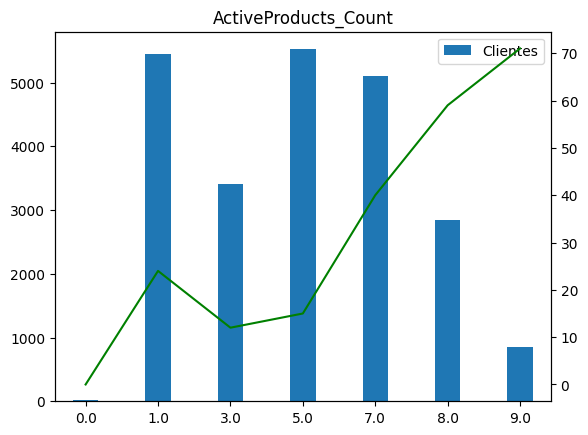

In [60]:
realizarAnalisisBivariado('ActiveProducts_Count')

- Has_Email



Covarianza: 17412334.5


,rank,amin,amax,Clientes,REAL_TARGET,TGT
0,1.0,0.0,0.0,6365,1747,27
1,6.0,1.0,1.0,16826,5076,30


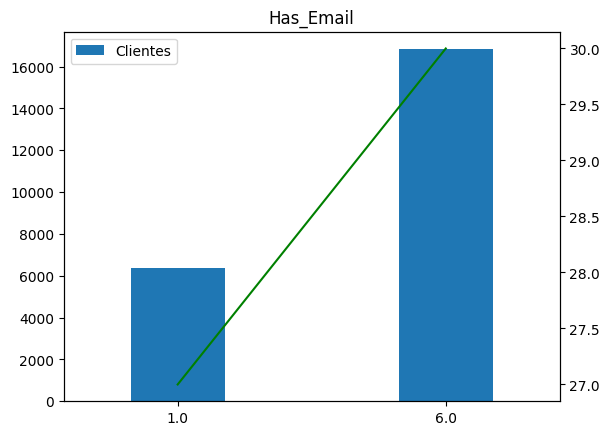

In [61]:
realizarAnalisisBivariado('Has_Email')

- Has_Mobile



Covarianza: 48862537.5


,rank,amin,amax,Clientes,REAL_TARGET,TGT
0,1.0,0.0,0.0,2758,647,23
1,5.0,1.0,1.0,20433,6176,30


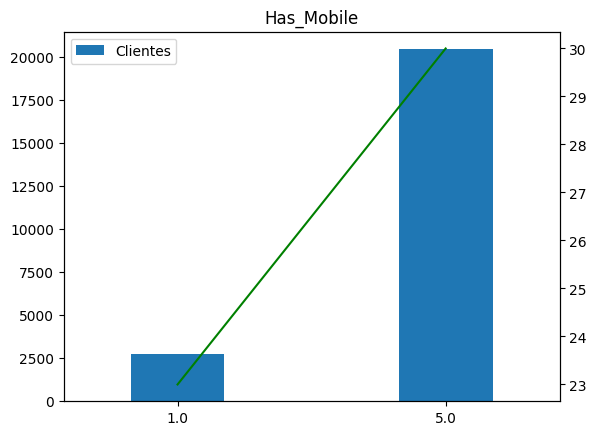

In [62]:
realizarAnalisisBivariado('Has_Mobile')

- CreditCard_Active



Covarianza: 19869217.5


,rank,amin,amax,Clientes,REAL_TARGET,TGT
0,2.0,0.0,0.0,8168,513,6
1,6.0,1.0,1.0,15023,6310,42


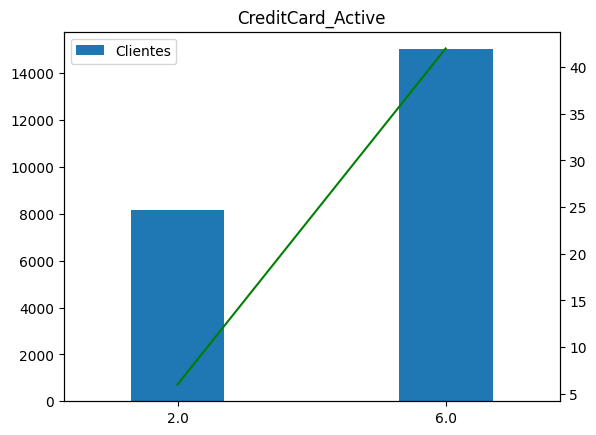

In [63]:
realizarAnalisisBivariado('CreditCard_Active')

- Mortgage_Active



Covarianza: 72451386.5


,rank,amin,amax,Clientes,REAL_TARGET,TGT
0,4.0,0.0,0.0,22672,6682,29
1,9.0,1.0,1.0,519,141,27


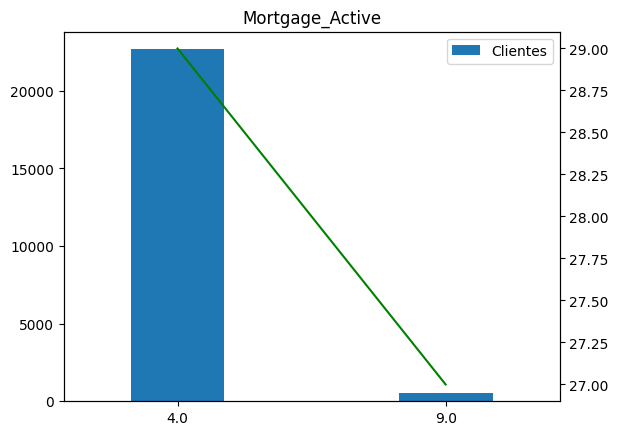

In [64]:
realizarAnalisisBivariado('Mortgage_Active')

- MonthsBetween_LastFirstProduct



Covarianza: 295277.4027777777


,rank,amin,amax,Clientes,REAL_TARGET,TGT
0,1.0,0.0,0.0,5271,1250,24
1,2.0,0.0,0.3,1173,97,8
2,3.0,0.3,10.1,2578,585,23
3,4.0,10.1,26.9,2572,672,26
4,5.0,27.0,36.7,2577,596,23
5,6.0,36.7,50.7,2577,761,30
6,7.0,50.7,73.1,2578,952,37
7,8.0,73.1,128.4,2577,1236,48
8,9.0,128.4,379.2,1288,674,52


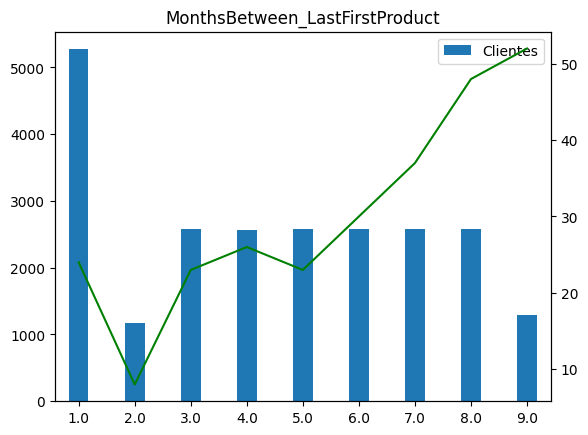

In [65]:
realizarAnalisisBivariado('MonthsBetween_LastFirstProduct')

- CreditCard_Total_Limit_nunique



Covarianza: 17239633.916666664


,rank,amin,amax,Clientes,REAL_TARGET,TGT
0,3.0,1.0,1.0,16387,5216,32
1,7.0,2.0,2.0,2680,499,19
2,8.0,3.0,3.0,4055,1101,27
3,9.0,4.0,4.0,69,7,10


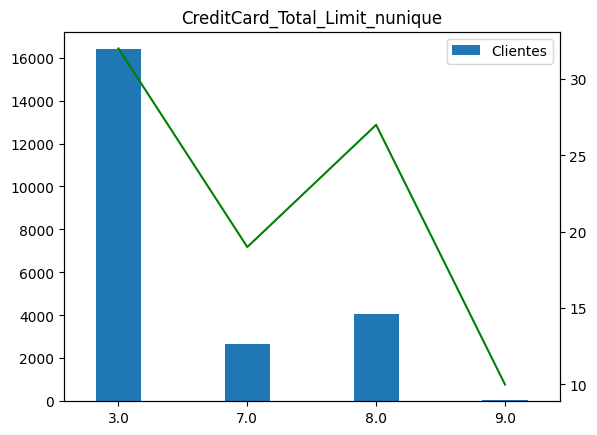

In [66]:
realizarAnalisisBivariado('CreditCard_Total_Limit_nunique')

- SavingAccount_Transfer_In_Amount_min



Covarianza: 37272188.333333336


,rank,amin,amax,Clientes,REAL_TARGET,TGT
0,4.0,0.0,0.0,20790,6079,29
1,8.0,1.0,4000.0,1117,295,26
2,9.0,4003.0,40661.0,1284,449,35


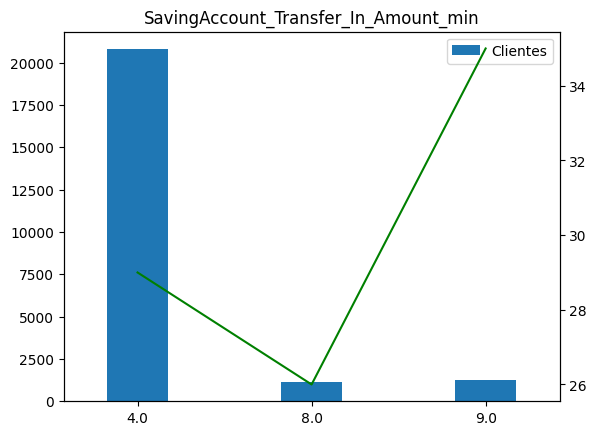

In [67]:
realizarAnalisisBivariado('SavingAccount_Transfer_In_Amount_min')

- Telemarketer_vs_Operations_min



Covarianza: 78724975.5


,rank,amin,amax,Clientes,REAL_TARGET,TGT
0,4.0,0.0,0.0,23171,6812,29
1,9.0,0.0,0.7,20,11,55


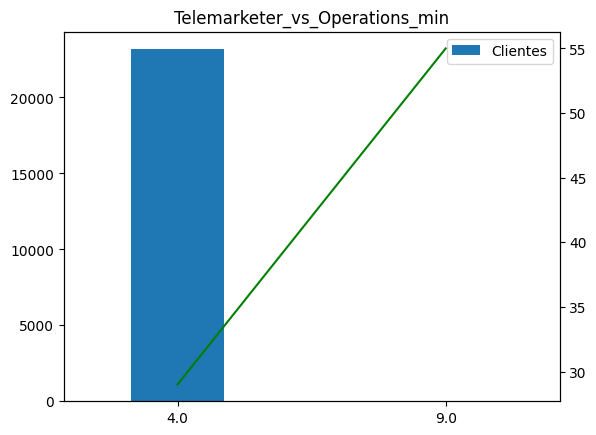

In [68]:
realizarAnalisisBivariado('Telemarketer_vs_Operations_min')

- Grupo Etario de Cliente



Covarianza: 1276028.3333333335


,rank,amin,amax,Clientes,REAL_TARGET,TGT
0,0.0,1.0,1.0,989,249,25
1,1.0,2.0,2.0,5308,1214,23
2,4.0,3.0,3.0,6563,1660,25
3,6.0,4.0,4.0,5149,1796,35
4,7.0,5.0,5.0,2122,776,37
5,8.0,6.0,6.0,1745,694,40
6,9.0,7.0,7.0,1315,434,33


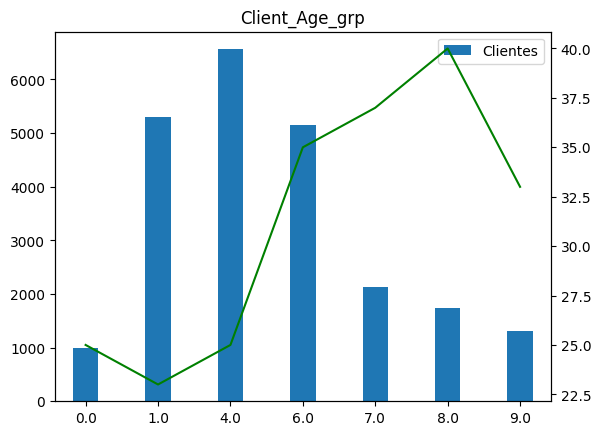

In [69]:
realizarAnalisisBivariado('Client_Age_grp')

- Tipo de Producto J55660104XX012



Covarianza: -3134092.5


,CreditCard_Product__J55660104XX012,Clientes,REAL_TARGET,TGT
0,0,14912,2939,19
1,1,8279,3884,46


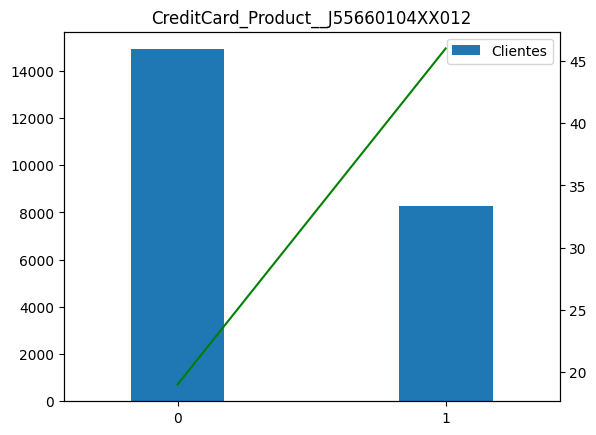

In [70]:
realizarAnalisisBivariado('CreditCard_Product__J55660104XX012')

## 11) Feature Importance

### _Estandarización_

In [71]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(ABT.select_dtypes('number'))#[cols])
dataScaled = pd.DataFrame(x)
print(dataScaled.shape)
dataScaled.head()

(23191, 134)


,0,1,2,3,4,5,6,7,8,9,...,124,125,126,127,128,129,130,131,132,133
0,0.697982,1.389060,1.548853,0.615048,0.367393,0.73736,-0.36109,0.702561,-0.335318,1.010621,...,-0.103968,-0.050072,3.418559,-0.656852,-0.31123,-0.496008,-0.275860,-0.433873,-0.342278,-0.745111
1,0.938076,0.027362,-0.645639,-1.625890,0.367393,-1.35619,-0.36109,0.702561,-0.335318,1.010621,...,-0.103968,-0.050072,-0.292521,-0.656852,-0.31123,2.016096,-0.275860,-0.433873,-0.342278,-0.745111
2,0.731454,0.027362,-0.645639,0.615048,0.367393,-1.35619,-0.36109,0.702561,-0.335318,1.010621,...,-0.103968,-0.050072,-0.292521,-0.656852,-0.31123,-0.496008,-0.275860,2.304820,-0.342278,-0.745111
3,-1.812134,0.027362,-0.645639,0.615048,0.367393,0.73736,-0.36109,0.702561,-0.335318,-0.989491,...,-0.103968,-0.050072,-0.292521,-0.656852,-0.31123,-0.496008,3.625032,-0.433873,-0.342278,-0.745111
4,-0.347591,-0.653487,-0.645639,-1.625890,0.367393,-1.35619,-0.36109,0.702561,-0.335318,-0.989491,...,-0.103968,-0.050072,-0.292521,-0.656852,-0.31123,2.016096,-0.275860,-0.433873,-0.342278,-0.745111


#### Estimar cantidad de variables necesarias mediante PCA

In [72]:
# @title Random State
RANDOM_STATE = 1 # @param {type:"integer"}

In [73]:
from sklearn.decomposition import PCA

cantidadColumnas = dataScaled.shape[1]
pca = PCA(n_components=cantidadColumnas, random_state=RANDOM_STATE)
data_PCA = pd.DataFrame(pca.fit_transform(dataScaled))

exp_var = pca.explained_variance_ratio_

exp_var.cumsum()

array([0.11076895, 0.17523452, 0.21336004, 0.24829639, 0.27942129,
       0.30884494, 0.33338452, 0.35508982, 0.37504321, 0.39399773,
       0.41196675, 0.42829707, 0.44357665, 0.45814245, 0.47196328,
       0.48526399, 0.49833857, 0.51105154, 0.52343741, 0.53547878,
       0.54669515, 0.55775   , 0.56875647, 0.5791561 , 0.58910786,
       0.59882721, 0.60841342, 0.61772052, 0.62691292, 0.63564947,
       0.64403053, 0.65235683, 0.6604404 , 0.66847749, 0.67636325,
       0.6841561 , 0.69186318, 0.6993729 , 0.70684663, 0.71429735,
       0.7216342 , 0.72886285, 0.73597287, 0.74298063, 0.74977498,
       0.75652281, 0.76314526, 0.76969635, 0.7761619 , 0.78233545,
       0.78849286, 0.79446686, 0.80027621, 0.80600687, 0.81167976,
       0.81713433, 0.8225586 , 0.82779709, 0.83293897, 0.83792939,
       0.8427471 , 0.84739864, 0.85197206, 0.85642   , 0.86077614,
       0.86508193, 0.86935   , 0.8735359 , 0.87767569, 0.88176178,
       0.88576575, 0.88969616, 0.8935268 , 0.89722631, 0.90081

Text(0, 0.5, 'Varianza Acumulada')

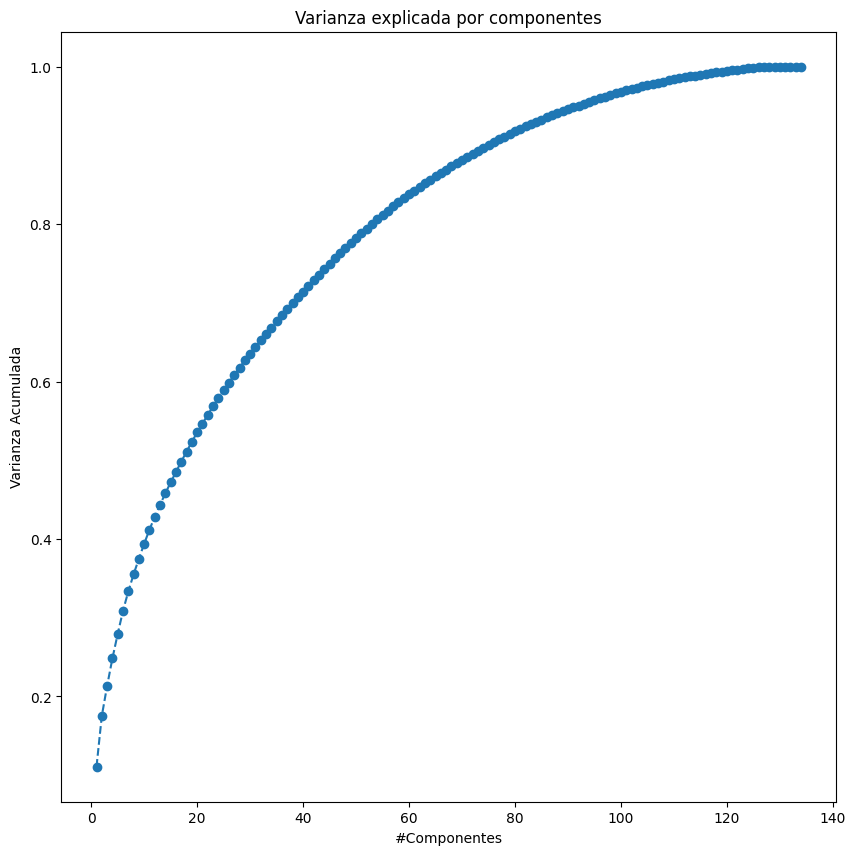

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10, 10) )
plt.plot(range(1, cantidadColumnas+1), exp_var.cumsum(), marker='o', linestyle='--')
plt.title('Varianza explicada por componentes')
plt.xlabel('#Componentes')
plt.ylabel('Varianza Acumulada')

In [75]:
# @title Varianza requerida
VARIANZA_DESEADA = 0.70 # @param {type:"number"}

cantidadVariables = 0
varAcumulada=0
for index, varianza in enumerate(exp_var):
  varAcumulada= varAcumulada+varianza
  if(varAcumulada>=VARIANZA_DESEADA):
    cantidadVariables = index+1

    break

print(f'La mínima cantidad de variables necesarias para lograr una varianza del {VARIANZA_DESEADA*100}% es de {cantidadVariables}')

La mínima cantidad de variables necesarias para lograr una varianza del 70.0% es de 39


#### Interpretación de los coeficientes de los componentes principales

In [76]:
def criterioResaltado(val):
  if val<=-0.25:
    return 'background: pink'
  elif val > 0.25:
    return 'background: skyblue'

pc = pd.DataFrame(np.round(pca.components_.T[:, 0:cantidadVariables], 2), index=dataScaled.columns, columns = map(lambda n: f'PCA {n}', range(1, cantidadVariables+1)) )
pc.select_dtypes('number').style.applymap(criterioResaltado)

,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,PCA 9,PCA 10,PCA 11,PCA 12,PCA 13,PCA 14,PCA 15,PCA 16,PCA 17,PCA 18,PCA 19,PCA 20,PCA 21,PCA 22,PCA 23,PCA 24,PCA 25,PCA 26,PCA 27,PCA 28,PCA 29,PCA 30,PCA 31,PCA 32,PCA 33,PCA 34,PCA 35,PCA 36,PCA 37,PCA 38,PCA 39
0,-0.000000,-0.090000,-0.020000,0.070000,-0.020000,0.040000,0.140000,-0.060000,-0.010000,-0.000000,-0.090000,0.270000,0.230000,-0.050000,-0.110000,0.120000,-0.100000,-0.080000,0.110000,0.020000,0.030000,-0.050000,-0.020000,-0.110000,0.050000,-0.060000,0.000000,0.040000,-0.030000,-0.010000,0.030000,0.070000,-0.020000,-0.070000,-0.040000,0.030000,-0.020000,0.020000,-0.000000
1,0.180000,-0.060000,0.060000,0.030000,-0.130000,0.120000,0.050000,-0.070000,0.140000,-0.060000,0.070000,-0.090000,0.120000,-0.050000,-0.000000,-0.080000,-0.030000,0.030000,-0.040000,0.020000,0.110000,-0.070000,0.050000,0.080000,-0.020000,0.030000,0.020000,-0.050000,-0.020000,-0.100000,0.030000,0.030000,0.030000,-0.070000,-0.010000,0.050000,-0.000000,0.010000,-0.000000
2,0.100000,0.090000,0.100000,-0.020000,-0.070000,-0.090000,-0.000000,-0.050000,0.050000,-0.010000,0.080000,0.000000,0.060000,-0.010000,0.000000,0.030000,0.000000,-0.000000,0.010000,0.010000,0.040000,-0.020000,-0.020000,0.000000,-0.030000,0.020000,-0.020000,-0.060000,-0.080000,-0.090000,0.070000,0.000000,-0.030000,-0.050000,-0.060000,0.060000,-0.030000,-0.030000,-0.020000
3,0.040000,0.010000,-0.040000,0.040000,-0.040000,0.080000,0.060000,-0.070000,-0.010000,-0.040000,-0.020000,0.020000,0.110000,-0.180000,0.000000,-0.090000,0.020000,-0.030000,-0.040000,-0.010000,0.080000,-0.080000,0.140000,0.000000,-0.100000,0.040000,-0.070000,-0.110000,0.030000,0.080000,-0.170000,-0.110000,-0.040000,0.140000,0.050000,-0.330000,-0.090000,-0.050000,-0.110000
4,0.030000,-0.000000,0.030000,0.030000,-0.040000,0.040000,0.030000,-0.030000,0.020000,-0.000000,-0.010000,0.010000,0.070000,-0.060000,-0.030000,-0.060000,-0.030000,-0.020000,-0.060000,-0.020000,0.050000,-0.070000,0.150000,0.010000,-0.080000,-0.050000,-0.110000,-0.100000,-0.010000,0.100000,-0.000000,-0.060000,-0.040000,0.260000,0.090000,-0.190000,-0.150000,-0.030000,-0.070000
5,0.050000,0.260000,0.010000,-0.010000,-0.050000,-0.100000,-0.030000,-0.100000,0.010000,-0.000000,0.060000,0.040000,0.070000,-0.100000,0.020000,0.110000,0.080000,-0.020000,0.010000,0.040000,0.070000,-0.050000,-0.030000,0.060000,0.000000,0.050000,0.020000,-0.070000,-0.070000,-0.020000,-0.020000,-0.000000,-0.030000,-0.050000,-0.060000,-0.010000,-0.080000,-0.010000,0.010000
6,0.020000,0.100000,-0.040000,-0.030000,0.010000,0.050000,0.090000,-0.000000,0.010000,-0.070000,-0.060000,0.080000,0.110000,-0.060000,-0.070000,0.010000,-0.010000,0.000000,0.060000,0.010000,0.050000,-0.040000,0.020000,0.000000,0.030000,0.090000,0.040000,-0.130000,-0.030000,-0.200000,-0.000000,0.000000,0.090000,-0.110000,-0.220000,0.040000,-0.010000,-0.070000,0.010000
7,0.120000,-0.150000,0.050000,0.060000,-0.120000,0.170000,0.050000,-0.040000,0.120000,-0.040000,0.040000,-0.080000,0.060000,-0.010000,-0.030000,-0.080000,-0.060000,0.020000,-0.050000,0.010000,0.040000,-0.010000,0.050000,0.020000,-0.000000,-0.040000,0.040000,0.030000,0.020000,-0.050000,0.010000,-0.000000,-0.010000,-0.040000,0.020000,0.030000,0.020000,0.030000,0.020000
8,0.130000,-0.100000,0.020000,-0.050000,0.100000,-0.210000,0.090000,-0.030000,0.090000,-0.060000,0.030000,0.010000,0.110000,0.090000,0.160000,-0.030000,-0.020000,-0.010000,-0.020000,-0.030000,0.040000,-0.020000,0.000000,0.020000,0.000000,0.030000,-0.160000,0.030000,-0.120000,-0.020000,0.010000,0.060000,-0.010000,-0.010000,-0.020000,0.020000,0.040000,-0.000000,0.020000
9,0.100000,-0.100000,0.010000,0.060000,-0.120000,0.150000,0.010000,-0.060000,0.100000,-0.010000,0.060000,-0.090000,0.090000,-0.070000,0.010000,-0.170000,-0.070000,0.020000,-0.090000,0.000000,0.080000,-0.040000,0.130000,0.060000,-0.070000,0.000000,-0.010000,-0.050000,0.050000,-0.030000,-0.040000,-0.050000,-0.020000,0.060000,0.050000,-0.150000,-0.060000,0.010000,-0.030000


### _Obtención de principales features_
> Se utiliza un modelo provisorio de tipo Light GBM

In [77]:
TARGET_COLUMN = 'REAL_TARGET'
OTHER_NUMERICAL_COLUMNS = ABT.columns.to_list()
OTHER_NUMERICAL_COLUMNS.remove('client_id')
OTHER_NUMERICAL_COLUMNS.remove(TARGET_COLUMN)

In [78]:
from scipy.stats import randint
from scipy.stats import uniform
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

clf = lgb.LGBMClassifier(
    random_state=314
#    , silent=True
    , metric='None'
#    , nfold=5
    , n_jobs=4
)

#------------------------------------------------------------------------

param_test= {
  'num_leaves': np.arange(5, 20, 1)
  , 'min_data_in_leaf': np.arange(10, 100, 1)
  , 'subsample': uniform(loc=0.2, scale=0.8)
  , 'max_depth': np.arange(5, 20, 1)
}

n_HP_points_to_test = 100

gs = RandomizedSearchCV(
  estimator = clf
  , param_distributions=param_test
  , n_iter = n_HP_points_to_test
  , scoring = 'roc_auc'
  , cv=3
  , refit=True
  , random_state=314
  , verbose=True
)

#------------------------------------------------------------------------

fit_params = {
#  'early_stopping_rounds': 100
   'eval_metric': 'auc'
  , 'eval_set': [ (ABT[OTHER_NUMERICAL_COLUMNS], ABT[TARGET_COLUMN])]
  #, 'callbacks': ...
 # , 'verbose': 100
}

gs.fit(ABT[OTHER_NUMERICAL_COLUMNS], ABT[TARGET_COLUMN], **fit_params)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Info] Number of positive: 4548, number of negative: 10912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11717
[LightGBM] [Info] Number of data points in the train set: 15460, number of used features: 127
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.294179 -> initscore=-0.875176
[LightGBM] [Info] Start training from score -0.875176
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will b

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(metric='None', n_jobs=4,
                                            random_state=314),
                   n_iter=100,
                   param_distributions={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'min_data_in_leaf': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99]),
                                        'num_leaves': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c742b730af0>},
                   random_state=314, scoring='roc_auc', verbose=True)

<Axes: >

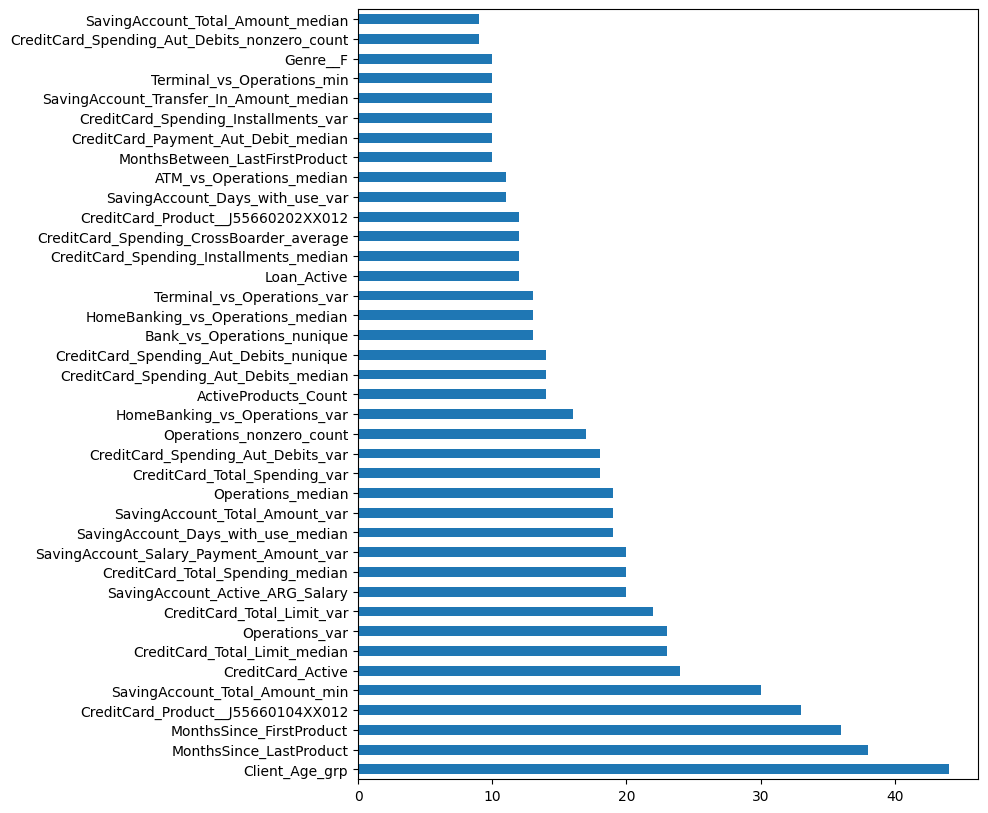

In [79]:
feat_imp = pd.Series(gs.best_estimator_.feature_importances_, index=ABT[OTHER_NUMERICAL_COLUMNS].columns)
feat_imp.nlargest(cantidadVariables).plot(kind='barh', figsize=(8,10))

In [80]:
principalesFeatures = feat_imp.nlargest(cantidadVariables).index.to_list()

### Listado de variables y pesos
> Para pegar en Excel (entregable)

In [81]:
s = '";"'.join(principalesFeatures)
print('Excel ={'+f'"{s}"'+'}')

Excel ={"Client_Age_grp";"MonthsSince_LastProduct";"MonthsSince_FirstProduct";"CreditCard_Product__J55660104XX012";"SavingAccount_Total_Amount_min";"CreditCard_Active";"CreditCard_Total_Limit_median";"Operations_var";"CreditCard_Total_Limit_var";"SavingAccount_Active_ARG_Salary";"CreditCard_Total_Spending_median";"SavingAccount_Salary_Payment_Amount_var";"SavingAccount_Days_with_use_median";"SavingAccount_Total_Amount_var";"Operations_median";"CreditCard_Total_Spending_var";"CreditCard_Spending_Aut_Debits_var";"Operations_nonzero_count";"HomeBanking_vs_Operations_var";"ActiveProducts_Count";"CreditCard_Spending_Aut_Debits_median";"CreditCard_Spending_Aut_Debits_nunique";"Bank_vs_Operations_nunique";"HomeBanking_vs_Operations_median";"Terminal_vs_Operations_var";"Loan_Active";"CreditCard_Spending_Installments_median";"CreditCard_Spending_CrossBoarder_average";"CreditCard_Product__J55660202XX012";"SavingAccount_Days_with_use_var";"ATM_vs_Operations_median";"MonthsBetween_LastFirstProduct

In [82]:
s = ';'.join(map(str, feat_imp.nlargest(cantidadVariables).values))
print('Excel ={'+s+'}')

Excel ={44;38;36;33;30;24;23;23;22;20;20;20;19;19;19;18;18;17;16;14;14;14;13;13;13;12;12;12;12;11;11;10;10;10;10;10;10;9;9}


### Detalle en prosa de variables

In [83]:
def interpretarSufijo(sufijo): return {
    '_nonzero_count': 'Cantidad de veces que fue distinto de 0', '_count': 'Cantidad total', '_nunique': 'Cantidad de números rondados sin repetir', '_first': 'primer', '_last': 'última ', '_var' : 'Varianza (es decir, una medida de la dispersión o alejamiento de la media)', '_average': 'Promedio', '_median': 'Mediana (percentil 50, es decir, el promedio considerando el 50% de las veces)', '_sum': 'Suma', '_min': 'Mínimo', '_max': 'Máximo'
}.get(sufijo.lower(), ROJO('[Yet not implemented suffix]'))

def definirBooleana(feature):
  return f'Indica si {feature} (1 para Sí y 0 para No)'

def definirFeature(feature):
  match feature:
    #Client
    case 'Client_Age_grp':
      grps = ", ".join([f"{gruposEtarios.index(gr)}='{gr}'" for gr in gruposEtarios])
      return f'Indica el grupo etario del cliente: {grps}'

    case clientRegion if 'Region' in clientRegion:
      region = feature.split('__')[1].replace('_', ' ')
      return definirBooleana(f"el cliente es habitante de la región '{region}'")

    #Personal data
    case genre if 'Genre' in genre:
      inicialGenero = feature.split('__')[1]
      genero = {'M': 'Masculino', 'F': 'Femenino'}[inicialGenero]
      return definirBooleana(f"el género del cliente es {genero}")

    case hasContact if hasContact.startswith('Has_'):
      medio = feature.split('Has_')[1]
      return definirBooleana(f'el cliente tiene asociado a su cuenta su {medio.lowercase()}')

    #CreditCard
    case 'CreditCard_Active':
      return definirBooleana('el cliente tiene contratada una tarjeta de crédito')

    case creditCardLimit if creditCardLimit.startswith('CreditCard_Total_Limit'):
      sufijo = creditCardLimit.split('CreditCard_Total_Limit')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de los límites que fue obteniendo la tarjeta de crédito del cliente.'

    case creditCardProduct if 'CreditCard_Product__' in creditCardProduct:
      return definirBooleana(f"el cliente tiene contratada una Tarjeta de Crédito de Tipo '{feature.split('CreditCard_Product__')[1]}'")

    case totalSpending if totalSpending.startswith('CreditCard_Total_Spending_'):
      return f'Indica la {interpretarSufijo(totalSpending.split("CreditCard_Total_Spending")[1])} de los gastos totales de la tarjeta de crédito asociada a la cuenta del cliente'

    case f if f.startswith('CreditCard_Spending_Aut_Debits_'):
      sufijo = f.split('CreditCard_Spending_Aut_Debits')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de las cantidades de dinero históricas debitados en forma automática de la tarjeta de crédito del cliente'

    case f if f.startswith('CreditCard_Payment_Aut_Debit_'):
      sufijo = f.split('CreditCard_Payment_Aut_Debit')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de las cantidades de débitos históricos realizados en forma automática de la tarjeta de crédito del cliente.'
    case f if f.startswith('CreditCard_Payment_External_'):
      sufijo = f.split('CreditCard_Payment_External')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de las cantidades de pagos históricos con tarjeta de crédito realizados por fuera del banco. Por ejemplo, en Pago Fácil o en RapiPago.'
    case f if f.startswith('Debit_vs_CreditCard_'):
      sufijo = f.split('Debit_vs_CreditCard')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de las relaciones históricas entre saldos de cuenta débito y crédito'
    case f if f.startswith('CreditCard_Spending_1_Installment_'):
      sufijo = f.split('CreditCard_Spending_1_Installment')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de los pagos mensuales históricos realizados al contado (en una sola cuota)'
    case f if f.startswith('CreditCard_Spending_Installments_'):
      sufijo = f.split('CreditCard_Spending_Installments')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de cuotas en que fueron realizados distintos pagos desde la tarjeta de crédito del cliente'

    case f if f.startswith('CreditCard_Spending_CrossBoarder_'):
      sufijo = f.split(('CreditCard_Spending_CrossBoarder'))[1]
      return f'Indica la {interpretarSufijo(sufijo)} de los gastos realizados fuera de Argentina.'
    #MonthsSince
    case monthsSince if monthsSince.startswith('MonthsSince_'):
      primeroOUltimo = {'LastProduct': 'último', 'FirstProduct': 'primer'}[feature.split('MonthsSince_')[1]]
      return f'Indica la cantidad de meses transcurridos desde el {primeroOUltimo} producto contratado por el cliente.'
    case 'MonthsBetween_LastFirstProduct':
      return 'Indica la cantidad de meses transcurridos entre la primera contratación y la última, llevadas a cabo por el cliente'
    #Operations
    case operations if operations.startswith('Operations'):
      return f"Indica la {interpretarSufijo(feature.split('Operations')[1])} de operaciones realizadas por el cliente."

    case vsOperations if '_vs_Operations' in vsOperations:
      partes = feature.split('_vs_Operations')
      return (f"{interpretarSufijo(partes[1])} del Porcentaje de Operaciones que fueron realizadas a través de {partes[0]}")

    #SavingAccounts
    case 'SavingAccount_Active_ARG_Salary':
      return 'Indica si el cliente tiene contratada una caja de ahorro en moneda argentina.'
    case f if f.startswith('SavingAccount_Total_Amount_'):
      sufijo = f.split('SavingAccount_Total_Amount')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de los saldos históricos de la caja de ahorro del cliente.'
    case f if f.startswith('SavingAccount_Salary_Payment_Amount_'):
      sufijo = f.split('SavingAccount_Salary_Payment_Amount')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de los ingresos de dinero en calidad de salario del cliente.'
    case f if f.startswith('SavingAccount_Salary_Payment_Transactions_'):
      sufijo = f.split('SavingAccount_Salary_Payment_Transactions')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de la cantidad de transacciones de la cuenta del cliente relacionadas a cobros de sueldos.'
    case f if f.startswith('SavingAccount_Days_with_use_'):
      sufijo = f.split('SavingAccount_Days_with_use')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de la cantidad total de días en que fue utilizada la caja de ahorro del cliente.'
    case f if f.startswith('SavingAccount_Transfer_In_Amount_'):
      sufijo = f.split('SavingAccount_Transfer_In_Amount')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de las cantidades de dinero transferido hacia la caja de ahorro del cliente en forma mensual'
    case f if f.startswith('SavingAccount_CreditCard_Payment_Transactions_'):
      sufijo = f.split('SavingAccount_CreditCard_Payment_Transactions')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de los pagos de la tarjeta de crédito realizados desde la caja de ahorro'

    case f if f.startswith('SavingAccount_DebitCard_Spend_Transactions_'):
      sufijo = f.split('SavingAccount_DebitCard_Spend_Transactions')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de las cantidades históricas de dinero abonadas con tarjeta de débito del cliente'

    case f if f.startswith('SavingAccount_Service_Payment_Amount_'):
      sufijo = f.split('SavingAccount_Service_Payment_Amount')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de las cantidades de transacciones correspondientes a pagos de servicios públicos (Agua, Gas, Electricidad, etc)'

    case f if f.startswith('SavingAccount_Transactions_Transactions_'):
      sufijo = f.split('SavingAccount_Transactions_Transactions')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de las cantidades de transacciones mensuales históricas.'

    #Active products
    case f if f.startswith('ActiveProducts_'):
      sufijo = f.split('ActiveProducts')[1]
      return f'Indica la {interpretarSufijo(sufijo)} de las cantidades históricas de productos contratados en simultáneo'
    case 'Loan_Active':
      return definirBooleana('la cuenta del cliente tiene préstamos habilitados.')
    case _:
      return ROJO('[Yet not defined]')

pf = principalesFeatures
#pf = filter(lambda f: ('Yet not ' in definirFeature(f)), pf)
#pf = filter(lambda f: not ('Yet not ' in definirFeature(f)), pf)

for index, feature in enumerate(pf):
  definicion = definirFeature(feature)
  blueIndex = AZUL(f"#{str(index+1).rjust(2, '0')}")
  print(f"{blueIndex}) {feature}: {definicion}")
  print('------------------------------------------------------------------------------------------')

#01) Client_Age_grp: Indica el grupo etario del cliente: 0='Menor a 18 años', 1='Entre 18 y 29 años', 2='Entre 30 y 39 años', 3='Entre 40 y 49 años', 4='Entre 50 y 59 años', 5='Entre 60 y 64 años', 6='Entre 65 y 69 años', 7='Mayor a 70 años'
------------------------------------------------------------------------------------------
#02) MonthsSince_LastProduct: Indica la cantidad de meses transcurridos desde el último producto contratado por el cliente.
------------------------------------------------------------------------------------------
#03) MonthsSince_FirstProduct: Indica la cantidad de meses transcurridos desde el primer producto contratado por el cliente.
------------------------------------------------------------------------------------------
#04) CreditCard_Product__J55660104XX012: Indica si el cliente tiene contratada una Tarjeta de Crédito de Tipo 'J55660104XX012' (1 para Sí y 0 para No)
-------------------------------------------------------------------------------------

## 12) Modelo Final

### _Balanceo de Datos_

In [84]:
tar = ABT.REAL_TARGET.value_counts()
tar

0    16368
1     6823
Name: REAL_TARGET, dtype: int64

In [85]:
#cantidadFilasPorBorrar = max(0, tar[0] - tar[1])
#balancedABT = ABT.drop(ABT[ABT[TARGET_COLUMN]==0].index[-cantidadFilasPorBorrar:])
def sampleByTGT(tgt):
  return ABT[ABT.REAL_TARGET == tgt].sample(n=tar[1], replace=True, random_state=RANDOM_STATE)
c0 = sampleByTGT(0)
c1 = sampleByTGT(1)
balancedABT = pd.concat([c0, c1])

In [86]:
balancedABT.REAL_TARGET.value_counts()

0    6823
1    6823
Name: REAL_TARGET, dtype: int64

### _División de datos (Entrenamiento y Validación)_

In [87]:
ABT_selected = balancedABT[['client_id', TARGET_COLUMN] + principalesFeatures]

In [88]:
# @title Parámetros
TEST_SIZE = 0.3 # @param {type:"number"}
RANDOM_STATE = 42 # @param {type:"number"}

In [89]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(ABT_selected, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=ABT_selected[TARGET_COLUMN])

In [90]:
x_train.REAL_TARGET.value_counts()

1    4776
0    4776
Name: REAL_TARGET, dtype: int64

In [91]:
x_test.REAL_TARGET.value_counts()

0    2047
1    2047
Name: REAL_TARGET, dtype: int64

### _Implementación del Modelo_
> Se usó el algoritmo Random Forrest

In [92]:
# @title Hiperparámetros
n_estimators = 10 # @param {type:"integer"}
max_depth = 5 # @param {type:"integer"}
RANDOM_STATE = 172 # @param {type:"integer"}
MIN_SAMPLES_LEAF = 85 # @param {type:"integer"}
MIN_SAMPLES_SPLIT = 305 # @param {type:"integer"}

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_squared_error

model = RandomForestClassifier(
  n_estimators=n_estimators,
  max_depth = max_depth,
  random_state=RANDOM_STATE,
  min_samples_leaf = MIN_SAMPLES_LEAF,
  min_samples_split= MIN_SAMPLES_SPLIT
)

X_train = x_train.drop(columns=[TARGET_COLUMN, 'client_id'])
Y_train = x_train.REAL_TARGET

#Entrenamiento
model.fit(X_train, Y_train)

# Validación
X_pred = x_test.drop(columns=[TARGET_COLUMN, 'client_id'])
Y_test = x_test.REAL_TARGET

Y_pred = model.predict(X_pred)

resultados = pd.DataFrame({
  'Métrica': ['Accuracy', 'Recall', 'F1-Score', 'Error Cuadrático Medio'],
  'Medida': [accuracy_score(Y_test, Y_pred), recall_score(Y_test, Y_pred), f1_score(Y_test, Y_pred), mean_squared_error(Y_test, Y_pred)]
})
resultados.style.hide(axis='index')

Métrica,Medida
Accuracy,0.757450
Recall,0.834392
F1-Score,0.774779
Error Cuadrático Medio,0.242550


### Modelo Generado

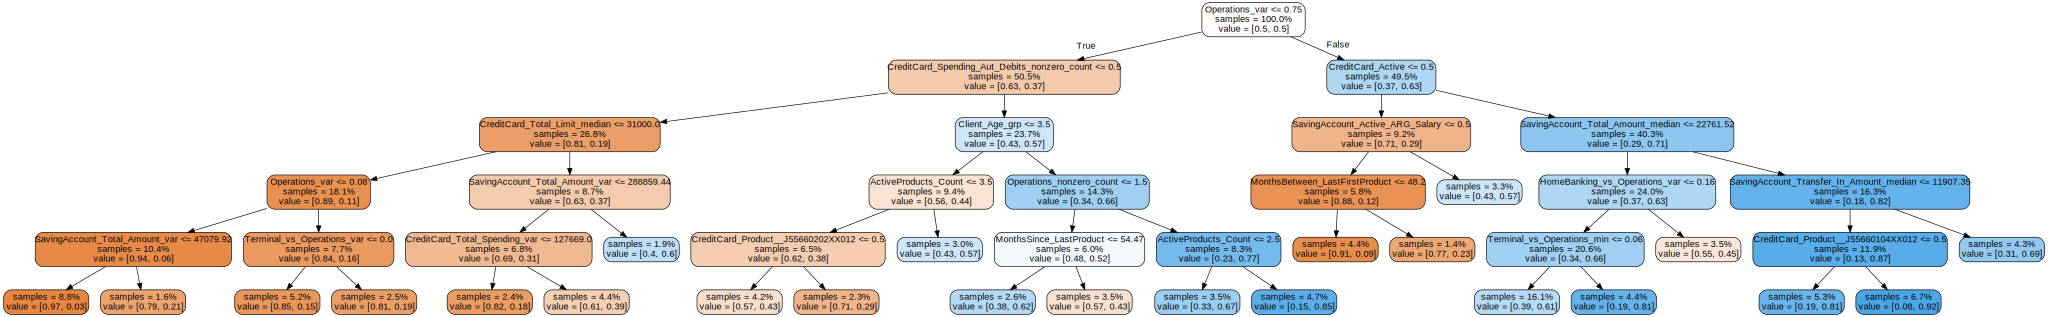

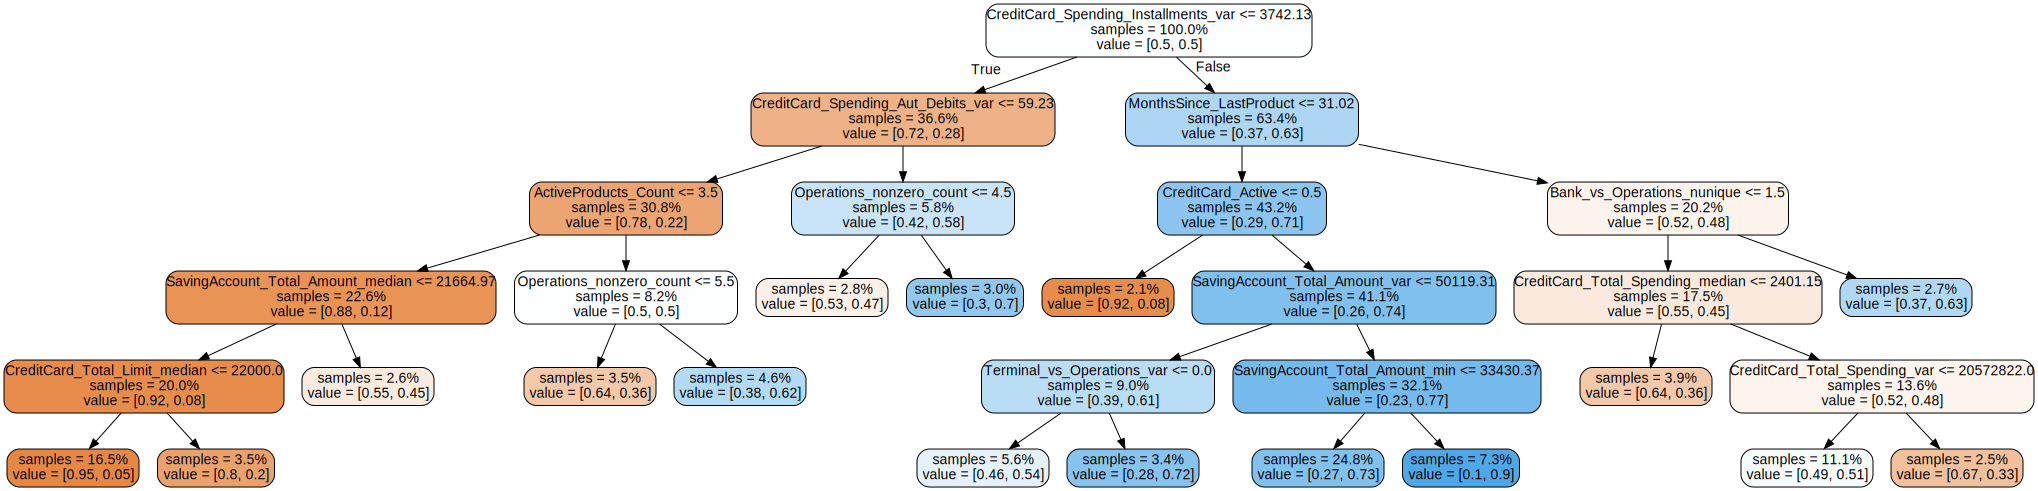

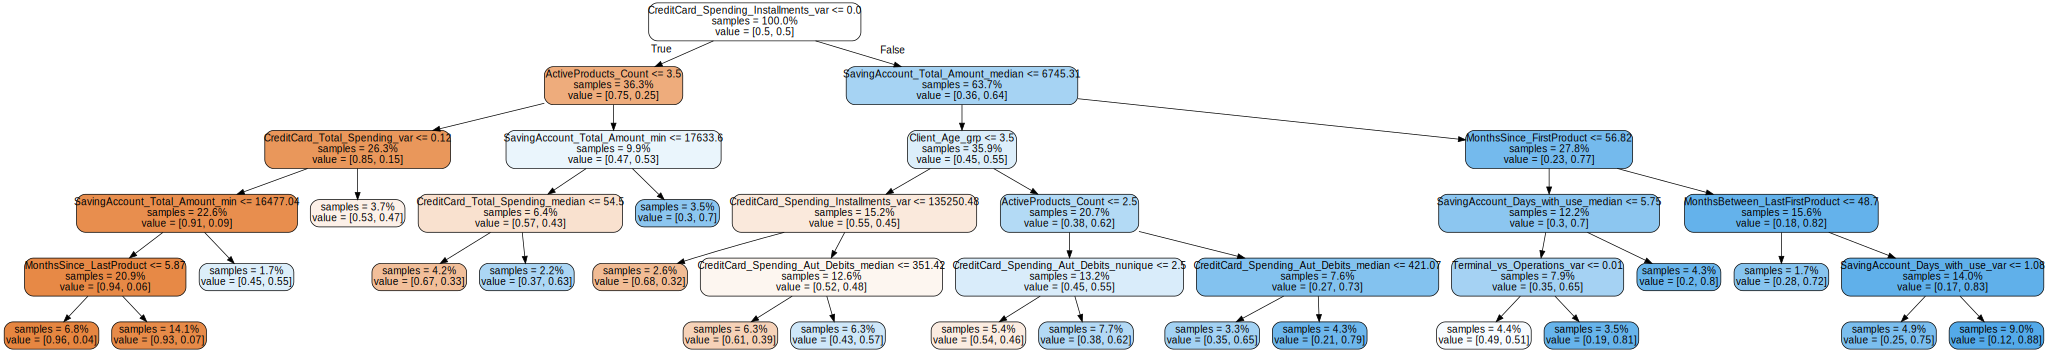

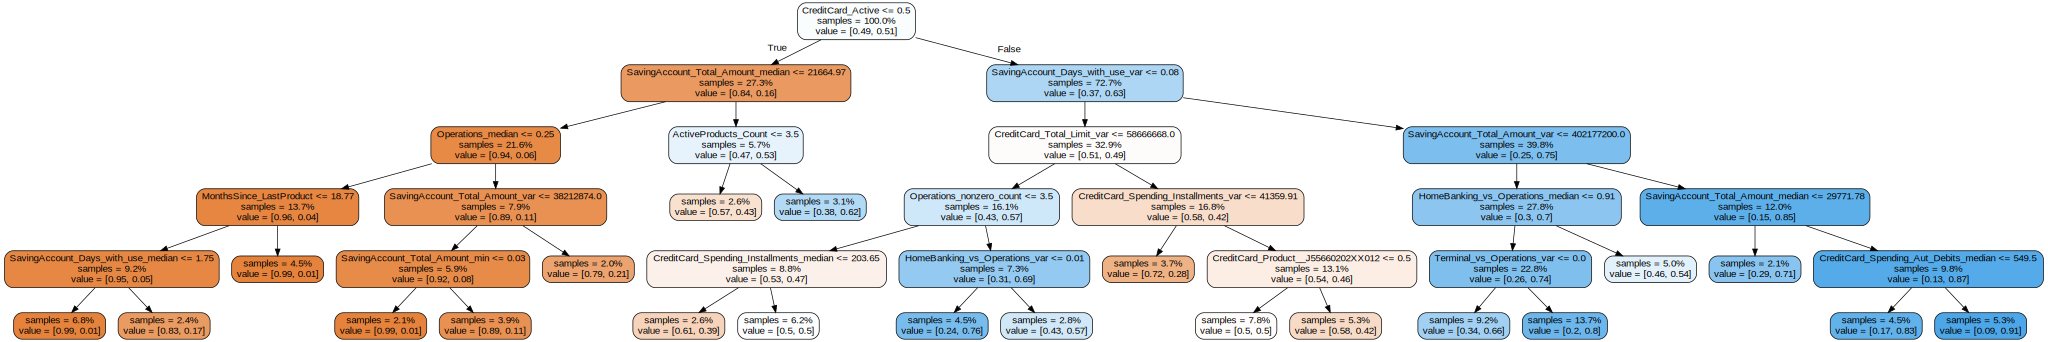

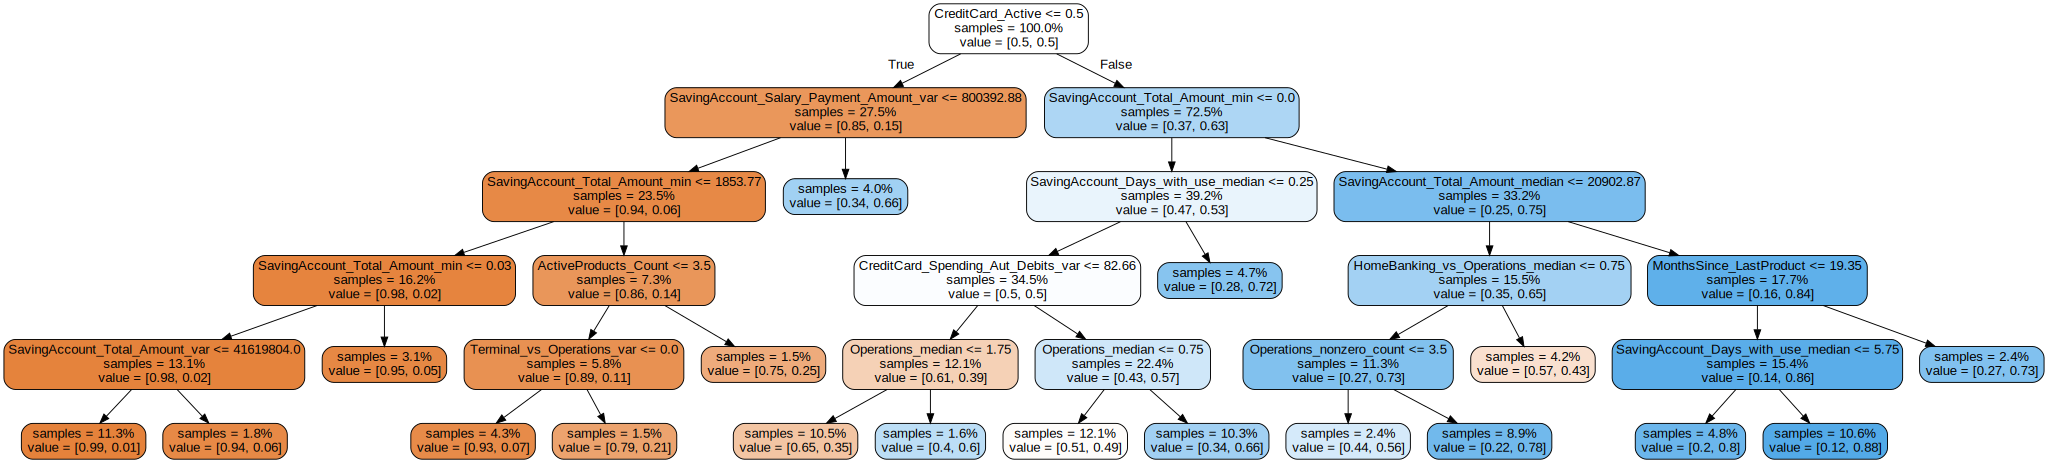

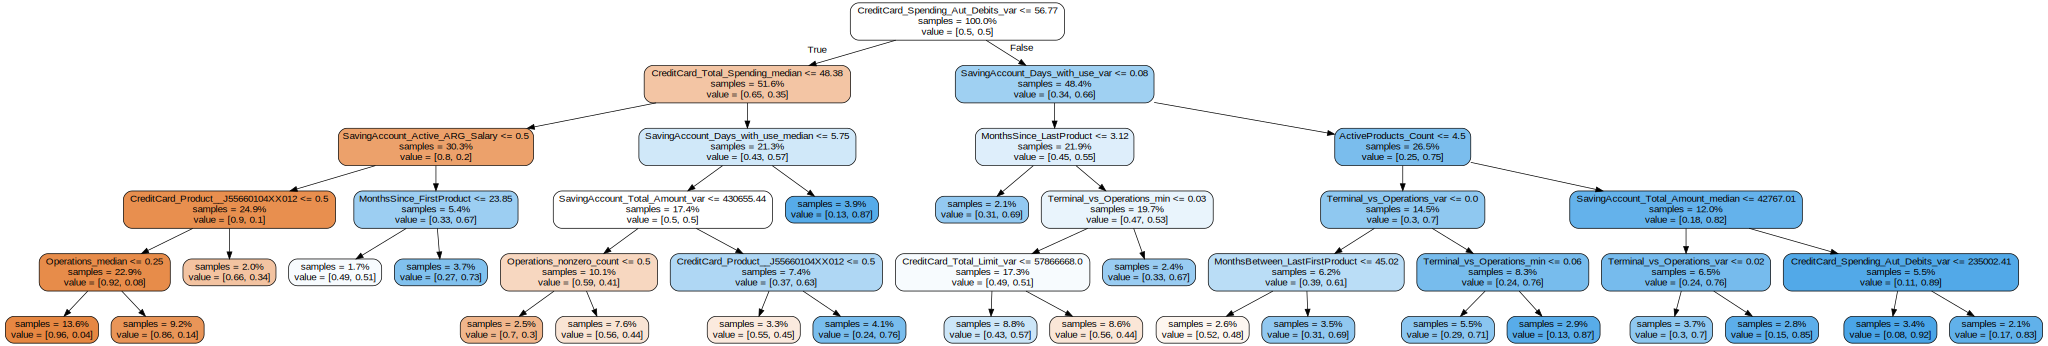

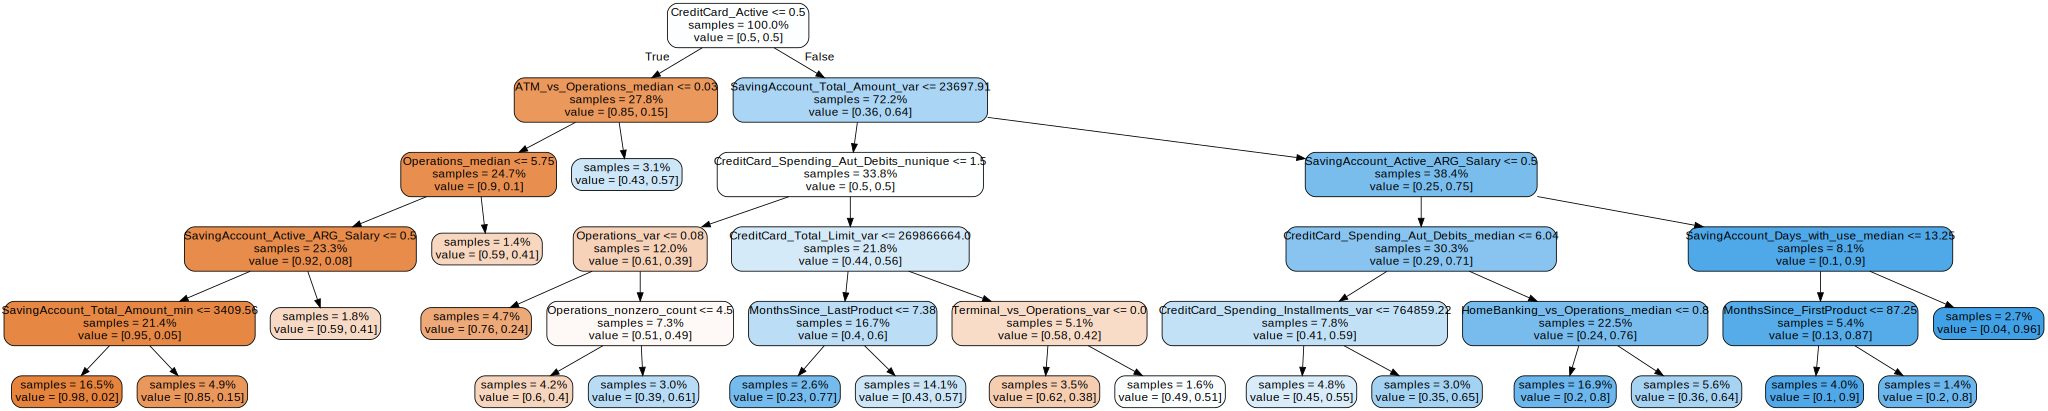

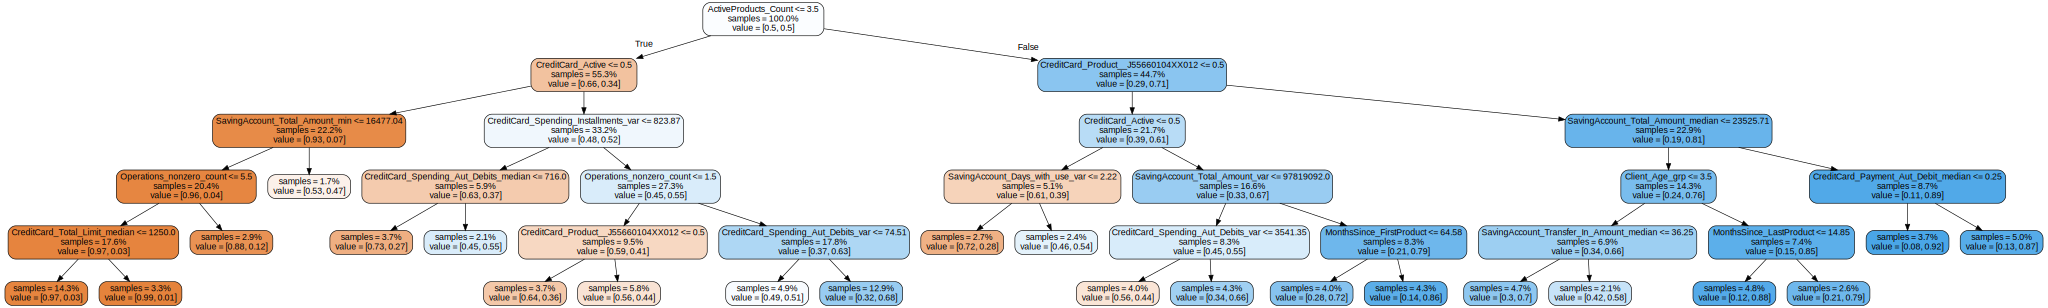

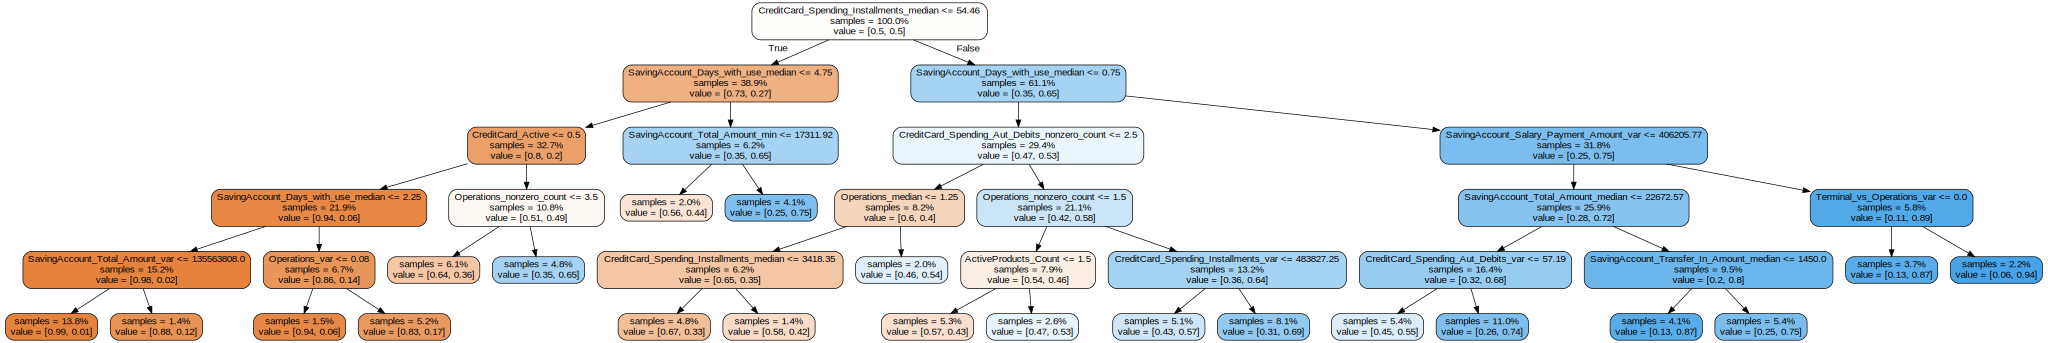

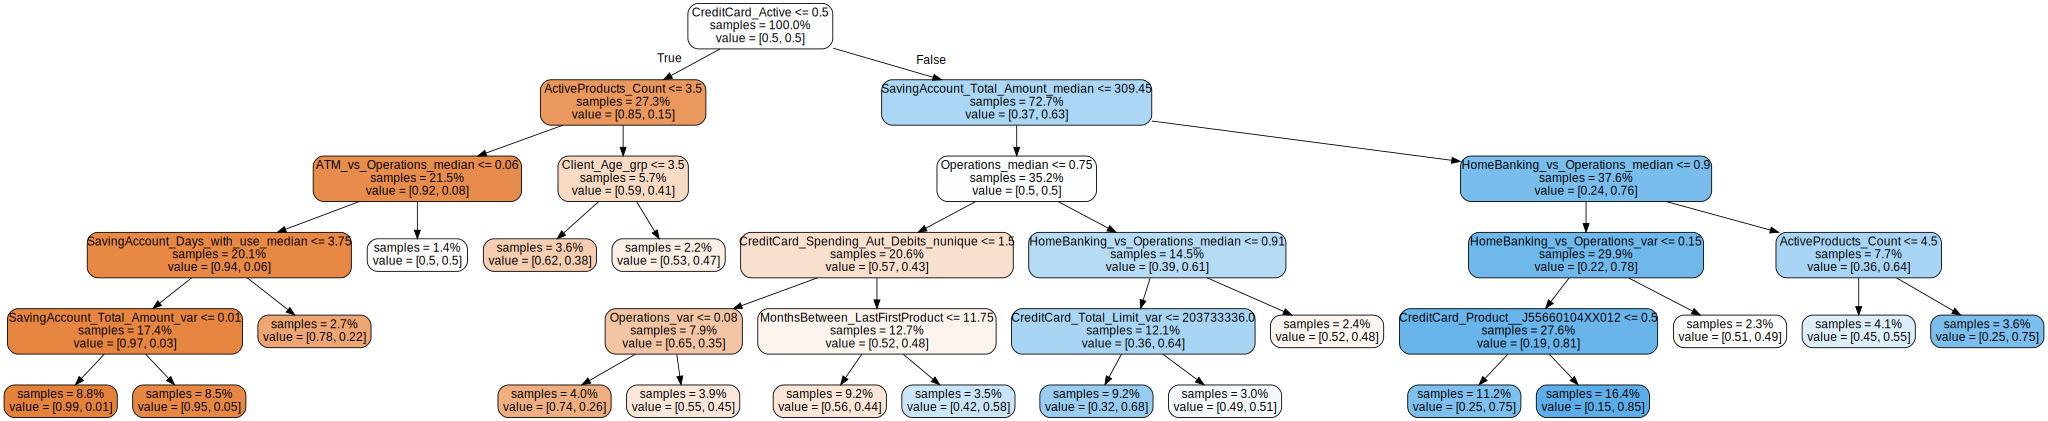

In [94]:
# @title Árboles
MAXIMA_PROFUNDIDAD = 5 # @param {type:"integer"}
CANTIDAD_DECIMALES = 2 # @param {type:"integer"}
COLOR = True # @param {type:"boolean"}
ESQUINAS_REDONDEADAS = True # @param {type:"boolean"}
PROPORTION = True # @param {type:"boolean"}
IMPURITY = False # @param {type:"boolean"}

from sklearn.tree import export_graphviz
from graphviz import Source

for tree in model.estimators_:
  plot = export_graphviz(tree, feature_names=X_train.columns, filled=COLOR, max_depth=MAXIMA_PROFUNDIDAD, rounded=ESQUINAS_REDONDEADAS, precision=CANTIDAD_DECIMALES, impurity=IMPURITY, proportion=PROPORTION)
  graph = Source(plot)
  ICD.display(graph)

#### Matriz de Confusión

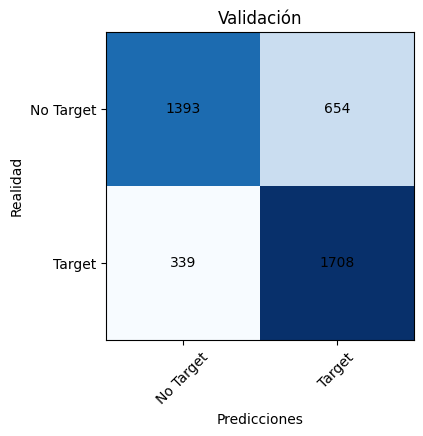

In [95]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(matrix, title, labels, ax):
    im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    # Puedo mostrar una barrita de color al costado, pero queda feo
    # ax.figure.colorbar(im, ax=ax)
    tick_marks = np.arange(len(labels))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Realidad')

    # Agregar números en las celdas de la matriz
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, str(matrix[i, j]), ha='center', va='center', color='black')

fig, (a1) = plt.subplots(1, 1, figsize=(4,4))
matrizConfusion = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(matrizConfusion, 'Validación', ['No Target', 'Target'], a1)

#### Error

In [96]:
def errorTipo2(matriz):
  porcentaje = '{:.2%}'
  return [
      porcentaje.format(1 - matriz[0][0]/matriz[0].sum()),
      porcentaje.format(1 - matriz[1][1]/matriz[1].sum())
  ]

def errorTipo1(matriz):
  return errorTipo2(matriz.T)

print_pretty(pd.DataFrame({'Error': ['No Target', 'Target'], 'Tipo I (FP)': errorTipo1(matrizConfusion), 'Tipo II (FN)': errorTipo2(matrizConfusion)}).style.hide(axis='index'))

Error,Tipo I (FP),Tipo II (FN)
No Target,19.57%,31.95%
Target,27.69%,16.56%


## 13) Evaluación del Modelo

In [97]:
def print_deciles(result, desc=''):
  deciles = result.decil.value_counts()
  print(f'Deciles {desc} '.ljust(30, '-'))
  sortedByIndex = deciles.sort_index().iloc[::-1]
  df = pd.DataFrame({'Decil': sortedByIndex.index, 'Cantidad': sortedByIndex.values})
  df = df.astype({'Decil': 'int'})
  print_pretty(df.style.hide(axis='index'))
  print('\nExcel:', '={'+'; '.join(map(str, sortedByIndex.values))+'}', '\n\n')

In [98]:
def manejarDeciles(proba, etapa, tgt, x):
  probas = [p[1] for p in proba]
  result = pd.concat([
    pd.DataFrame({'TGT': tgt, 'idx': x.index}).reset_index(),
    pd.DataFrame({'Prob1': probas}, columns=['Prob1'])
  ], axis=1)
  result['porc'] = result['Prob1'].rank(pct=True) * 100
  result['decil'] = pd.cut(result['porc'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=list(range(10, 0, -1)))

  print(AZUL(f'[{etapa}]'))
  print_deciles(result)
  print_deciles(result[result.TGT==1], 'de Targets')

### _Datos de Entrenamiento_

In [99]:
# Scoreo la base completa con el modelo final (mejores hiperparametros)
probabilities_train = model.predict_proba(X_train)

manejarDeciles(probabilities_train, 'Entrenamiento', Y_train, X_train)

[Entrenamiento]
Deciles  ---------------------


Decil,Cantidad
1,955
2,956
3,956
4,952
5,956
6,954
7,961
8,952
9,955
10,955



Excel: ={955; 956; 956; 952; 956; 954; 961; 952; 955; 955} 


Deciles de Targets -----------


Decil,Cantidad
1,861
2,811
3,706
4,639
5,566
6,484
7,400
8,235
9,70
10,4



Excel: ={861; 811; 706; 639; 566; 484; 400; 235; 70; 4} 




### _Datos de Validación_

In [100]:
probabilities       = model.predict_proba(X_pred)
manejarDeciles(probabilities, 'Validación', Y_test, X_pred)

[Validación]
Deciles  ---------------------


Decil,Cantidad
1,410
2,409
3,410
4,409
5,409
6,410
7,409
8,410
9,409
10,409



Excel: ={410; 409; 410; 409; 409; 410; 409; 410; 409; 409} 


Deciles de Targets -----------


Decil,Cantidad
1,373
2,333
3,315
4,286
5,242
6,213
7,158
8,101
9,21
10,5



Excel: ={373; 333; 315; 286; 242; 213; 158; 101; 21; 5} 




### _Curva ROC_
#### _(Reciever Operating Characteristic)_

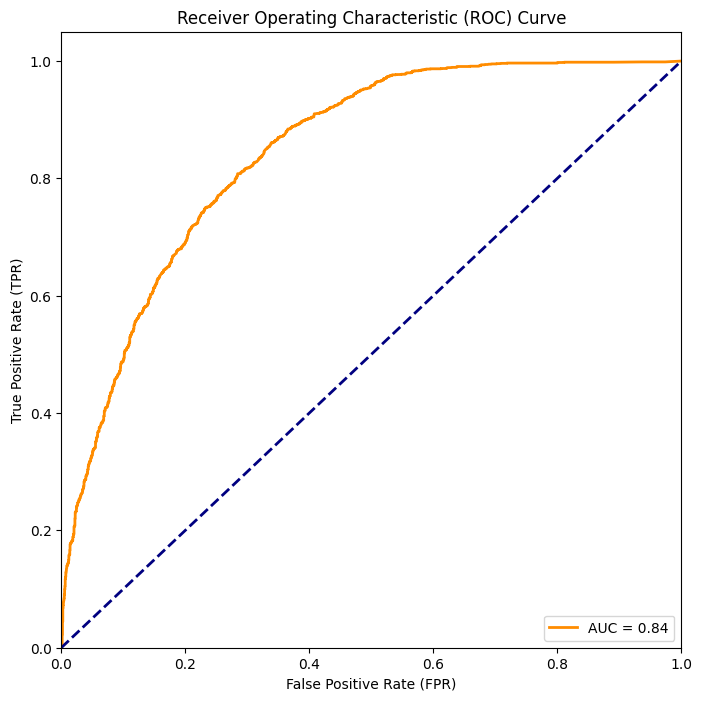

In [101]:
# Show ROC curve with TRP vs FPR graph

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, [p[1] for p in probabilities])
roc_auc = auc(fpr, tpr)

# Graph ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
